In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.patches as mpatches
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import f_oneway, bartlett, shapiro, ttest_ind, mannwhitneyu, levene, pearsonr, kruskal
from colorama import Fore, Back, Style
from keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor

# Read Data from CSVs

In [2]:
#load data from CSV
df_uncleaned = pd.read_csv('./data/stack-overflow-developer-survey-2023/survey_results_public.csv');
cf = pd.read_csv('./data/numbeo-cost-of-living-2023/cost_of_living_data.csv');
cuRate = pd.read_csv("./data/xe.com currency rates/currency_mid_2023.csv")

# Cleaning
#### 1. Remove the rows with null/na in country, total compensation as real income cannot be calaculated for such data points
#### 2. Remove few irrelevant columns

In [3]:
print(df_uncleaned.shape)
df = df_uncleaned.dropna(subset=['Country','CompTotal'])
print(df.shape)
df = df.loc[df["CompTotal"] != 0]
print(df.shape)
columns_to_remove = ['ResponseId','Q120', 'SurveyEase',"SurveyLength","LanguageWantToWorkWith","DatabaseWantToWorkWith","PlatformWantToWorkWith","WebframeWantToWorkWith",
                     "MiscTechWantToWorkWith","ToolsTechWantToWorkWith","BuyNewTool","NEWCollabToolsWantToWorkWith","OfficeStackAsyncWantToWorkWith","OfficeStackSyncWantToWorkWith",
                     "PurchaseInfluence","AISearchWantToWorkWith","AIDevWantToWorkWith","AISent","AIToolInterested in Using","AIToolNot interested in Using","SOAI","Knowledge_1","Knowledge_2",
                     "Knowledge_3","Knowledge_4","Knowledge_5","TechList","Knowledge_6","Knowledge_7","Knowledge_8","Frequency_1","Frequency_2","Frequency_3","TimeSearching",
                     "TimeAnswering","ProfessionalTech","OfficeStackSyncHaveWorkedWith","NEWSOSites","SOVisitFreq","SOAccount","SOComm","TBranch","AIAcc","AIBen","AINextSomewhat different",
                     "AINextVery similar","AINextSomewhat similar","AINextNeither different nor similar","AINextVery different","AINextNeither different nor similar"]
df = df.drop(columns_to_remove, axis=1)
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(89184, 84)
(48225, 84)
(48095, 84)
(48095, 35)
(48095, 35)


# Tranformation
#### 1. Normalize country names and education level
#### 2. Remove few countries with missing cost of living data
#### 3. Add currnecy conversion rate according to scraped rates for 1 July 2023
#### 4. Convert each currency to USD and calculate real adjusted income
#### 5. Convert professional coding experience to float with less then 1 year as 0.5 and more then 50 years as 55
#### 6. Remove top and bottom 1% of real income as they are outliers (with extremely high or 0 salary)

In [4]:
countries_to_remove=["nomadic","tajikistan","djibouti","lao people's democratic republic","turkmenistan","mozambique","gabon","mali","guinea-bissau","palau","timor-leste","malawi","togo","angola","sierra leone","mauritania","saint lucia","monaco","swaziland","lesotho","niger","dominica","liechtenstein","saint kitts and nevis","suriname","burundi","cape verde","sudan","guinea","saint vincent and the grenadines","burkina faso","antigua and barbuda"]
cf['Country'] = cf['Country'].str.strip().str.lower()
df['Country'] = df['Country'].str.strip().str.lower()
df = df[~df['Country'].isin(countries_to_remove)]
print(df.shape)

(48024, 35)


In [5]:
## Map country names between stack overflow and numbeo's data and create a county wise map for cost of living
col_required_for_countries = list(df["Country"].unique())
countries_found = list(cf["Country"].unique())
country_mapping = {"united states of america":"united states",
"united kingdom of great britain and northern ireland":"united kingdom",
"iran, islamic republic of...":"iran",
"russian federation":"russia",
"kosovo":"kosovo (disputed territory)",
"republic of korea":"south korea",
"viet nam":"vietnam",
"the former yugoslav republic of macedonia":"north macedonia",
"venezuela, bolivarian republic of...":"venezuela",
"hong kong (s.a.r.)":"hong kong (china)",
"republic of moldova":"moldova",
"syrian arab republic":"syria",
"united republic of tanzania":"tanzania",
"taiwan":"taiwan (china)",
"brunei darussalam":"brunei",
"libyan arab jamahiriya":"libya"}
cost_of_living = {}

unknown_col_count=0;
for country in col_required_for_countries:
    if country in countries_found:
        cost_of_living_index = cf.loc[cf["Country"] == country, "Cost of Living Index"].values[0]
        cost_of_living[country] = float(cost_of_living_index)
    elif country in country_mapping.keys():
        cost_of_living_index = cf.loc[cf["Country"] == country_mapping[country], "Cost of Living Index"].values[0]
        cost_of_living[country] = float(cost_of_living_index)
    else:
        unknown_col_count+=1;

if unknown_col_count > 0:
        raise ValueError("Cost of living information of some countries is not avaliable")

#Add cost of living index in df
df["CostOfLiving"] = df['Country'].map(cost_of_living)

In [6]:
#calculate real income after currency conversion in USD
currency_map = dict(zip(cuRate['Currency'], cuRate['Units per USD']))

df['ConversionRate'] = df['Currency'].str[:3].map(currency_map)
df["ConvertedCompYearly"] = df["CompTotal"]/df["ConversionRate"]
df['RealIncome'] = df["ConvertedCompYearly"]/df["CostOfLiving"]
df = df.drop(["ConversionRate","CostOfLiving","CompTotal","ConvertedCompYearly"], axis=1)


In [7]:
(len(df) - df['AIToolCurrently Using'].isna().sum())/len(df)


0.4071714142928536

In [8]:
df['YearsCodePro'] = df['YearsCodePro'].apply(lambda val: int(val) if str(val).isdigit() else (0 if val == "Less than 1 year" else (55 if val == "More than 50 years" else val)))
df['YearsCode'] = df['YearsCode'].apply(lambda val: int(val) if str(val).isdigit() else (0 if val == "Less than 1 year" else (55 if val == "More than 50 years" else val)))
df['WorkExp'] = df['WorkExp'].fillna(0).astype(int)
df['YearsCodePro'] = df['YearsCodePro'].fillna(0).astype(int)
df['YearsCode'] = df['YearsCode'].fillna(0).astype(int)
df['OrgSize'] = df['OrgSize'].fillna('I don’t know')
df['SOPartFreq'] = df['SOPartFreq'].fillna("I have never participated in Q&A on Stack Overflow")
df = df.fillna('na')

In [9]:
outlier_percent = 0.01

column_name = 'RealIncome'

# Calculate the 1st and 99th percentiles
ql = df[column_name].quantile(outlier_percent)
qu = df[column_name].quantile(1 - outlier_percent)

mask = (df[column_name] < ql) | (df[column_name] > qu)
df = df[~mask]


In [10]:
df['EdLevel'] = df['EdLevel'].replace("Bachelor’s degree (B.A., B.S., B.Eng., etc.)", "Bachelor's degree")
df['EdLevel'] = df['EdLevel'].replace("Master’s degree (M.A., M.S., M.Eng., MBA, etc.)", "Master’s degree")
df['EdLevel'] = df['EdLevel'].replace("Professional degree (JD, MD, Ph.D, Ed.D, etc.)", "Professional degree")
df['EdLevel'] = df['EdLevel'].replace("Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)", "Secondary school")
df['EdLevel'] = df['EdLevel'].replace("Associate degree (A.A., A.S., etc.)", "Associate degree")
df['EdLevel'] = df['EdLevel'].replace("Some college/university study without earning a degree", "Incomplete college/univ. study")

In [11]:
df[df["AISelect"] != 'na'].shape[0]/df.shape[0]

1.0

In [12]:
df.shape

(47062, 34)

In [13]:
df.RemoteWork.value_counts()

RemoteWork
Remote                                  20675
Hybrid (some remote, some in-person)    19950
In-person                                6369
na                                         68
Name: count, dtype: int64

## Visualisation

In [14]:
def printStats(stats, str, num=5):
    print(Fore.GREEN + f"1. Top {num} {str} paying maximum equitable salary on average:")
    print(Style.RESET_ALL)
    print(stats.sort_values(by='mean', ascending = False)[:5][["count","mean"]])
    print()
    print(Fore.RED + f"2. Top {num} {str} paying worst equitable salaries on average:")
    print(Style.RESET_ALL)
    print(stats.sort_values(by='mean')[:5][["count","mean"]])
    print(Fore.RED + f"3. Top {num} " + str + " paying worst minimum equitable salaries:")
    print(Style.RESET_ALL)
    print(stats.sort_values(by='min')[:5][["count","min"]])
    print()
    print(Fore.GREEN + f"4. Top {num} {str} paying some of the best maximum equitable salaries:")
    print(Style.RESET_ALL)
    print(stats.sort_values(by='max', ascending = False)[:5][["count","max"]])
    print()
    print(Fore.RED + f"5. Top {num} {str} with the highest variations in salaries:")
    print(Style.RESET_ALL)
    print(stats.sort_values(by='std', ascending=False)[:5][["count", "std"]])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean: 1922.48, Median: 1689.76, Mode: 2459.02


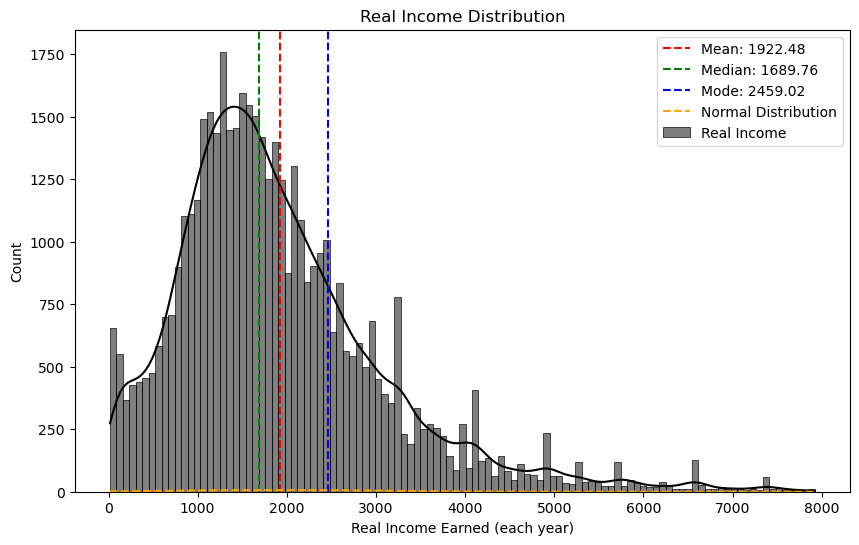

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm


plt.figure(figsize=(10, 6))

# Create the histogram plot with count
sns.histplot(df['RealIncome'], stat='count', color='black', kde=True, label="Real Income")

# Calculate mean, median, and mode
mean = df['RealIncome'].mean()
median = df['RealIncome'].median()
mode = df['RealIncome'].mode().values[0]  # Assuming the mode is unique

# Print the mean, median, and mode
print(f"Mean: {mean:.2f}, Median: {median:.2f}, Mode: {mode:.2f}")

# Add vertical lines for mean, median, and mode
plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='g', linestyle='--', label=f'Median: {median:.2f}')
plt.axvline(mode, color='b', linestyle='--', label=f'Mode: {mode:.2f}')

# Plot the normal distribution curve
x = np.linspace(df['RealIncome'].min(), df['RealIncome'].max(), 100)
y = norm.pdf(x, loc=mean, scale=df['RealIncome'].std())
plt.plot(x, y * len(df['RealIncome']) * 0.4, 'orange', linestyle='--', label='Normal Distribution')  # Scaling the normal curve


plt.title('Real Income Distribution')
plt.xlabel('Real Income Earned (each year)')
plt.ylabel('Count')
plt.legend()
plt.show()

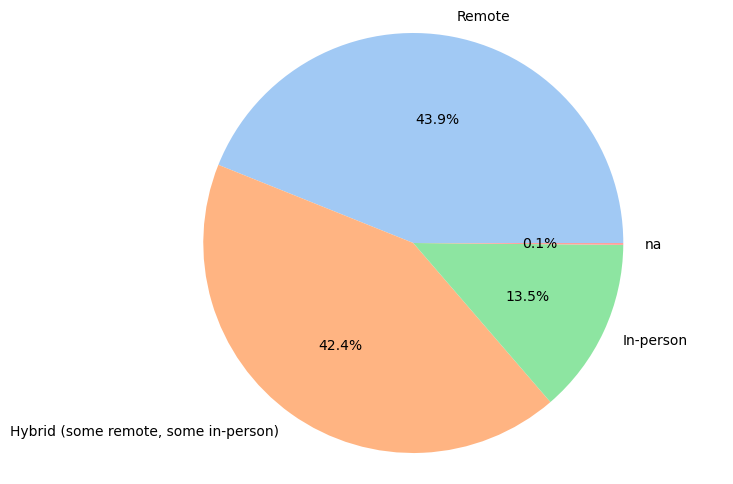

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'df' with a column 'RemoteWork'
column = df['RemoteWork']

# Calculate the frequency counts and percentages
freq_counts = column.value_counts()
total = freq_counts.sum()  # Total number of occurrences
freq_percentages = (freq_counts / total) * 100  # Calculate percentages

# Create a DataFrame with frequencies and percentages
freq_dist = pd.DataFrame({'Value': freq_counts.index, 'Percentage (%)': freq_percentages})

# Sort the DataFrame by percentage in descending order
freq_dist = freq_dist.sort_values(by='Percentage (%)', ascending=False)

# Create a pie plot with Seaborn colors
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')  # Choose a lighter color palette
plt.pie(freq_dist['Percentage (%)'], labels=freq_dist['Value'], colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

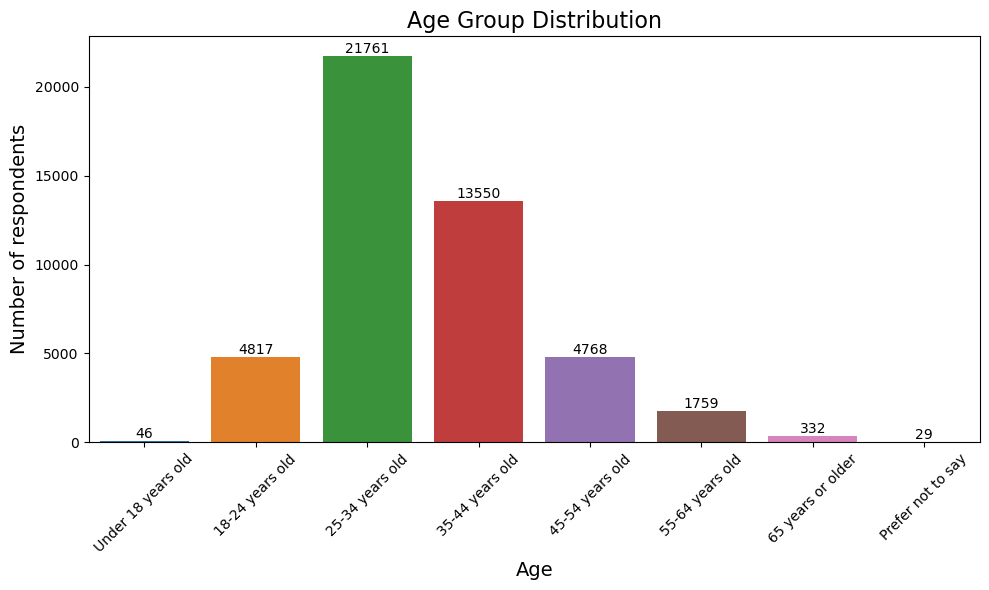

In [17]:
age_buckets = ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old',
               '45-54 years old', '55-64 years old', '65 years or older', 'Prefer not to say']
category_counts = df['Age'].value_counts()

sorted_category_counts = category_counts.reindex(age_buckets)
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_category_counts.index, y=sorted_category_counts.values)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of respondents', fontsize=14)
plt.title('Age Group Distribution', fontsize=16)
plt.xticks(rotation=45)

for index, value in enumerate(sorted_category_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

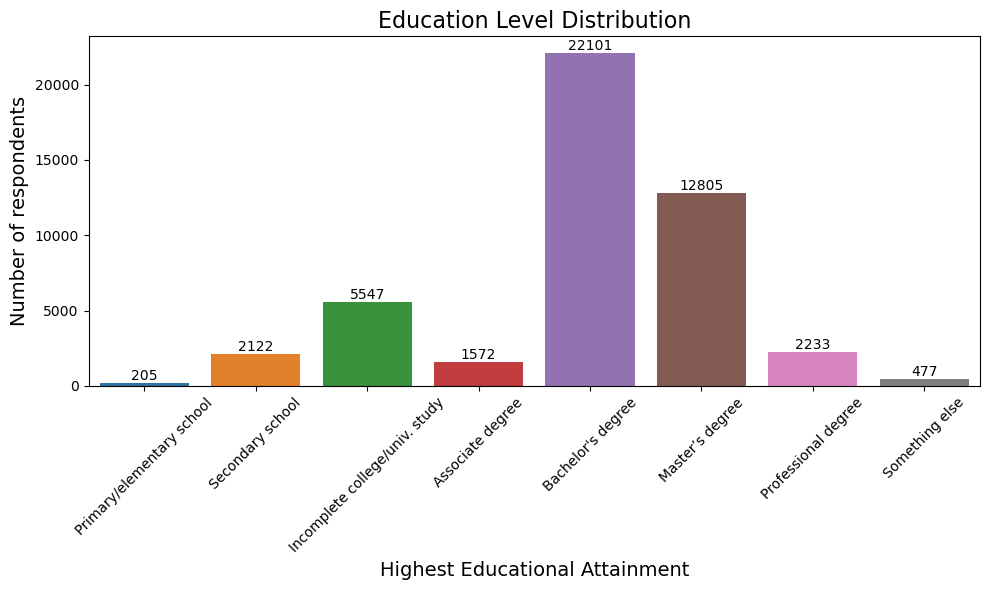

In [18]:
age_buckets = ["Primary/elementary school","Secondary school","Incomplete college/univ. study","Associate degree","Bachelor's degree","Master’s degree","Professional degree","Something else"]
category_counts = df['EdLevel'].value_counts()

sorted_category_counts = category_counts.reindex(age_buckets)
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_category_counts.index, y=sorted_category_counts.values)

plt.xlabel('Highest Educational Attainment', fontsize=14)
plt.ylabel('Number of respondents', fontsize=14)
plt.title('Education Level Distribution', fontsize=16)
plt.xticks(rotation=45)

for index, value in enumerate(sorted_category_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [19]:
df.Industry.value_counts()

Industry
na                                                                     19812
Information Services, IT, Software Development, or other Technology    13213
Financial Services                                                      3352
Other                                                                   2968
Manufacturing, Transportation, or Supply Chain                          1977
Healthcare                                                              1683
Retail and Consumer Services                                            1533
Higher Education                                                         853
Advertising Services                                                     597
Insurance                                                                570
Oil & Gas                                                                206
Legal Services                                                           164
Wholesale                                                          

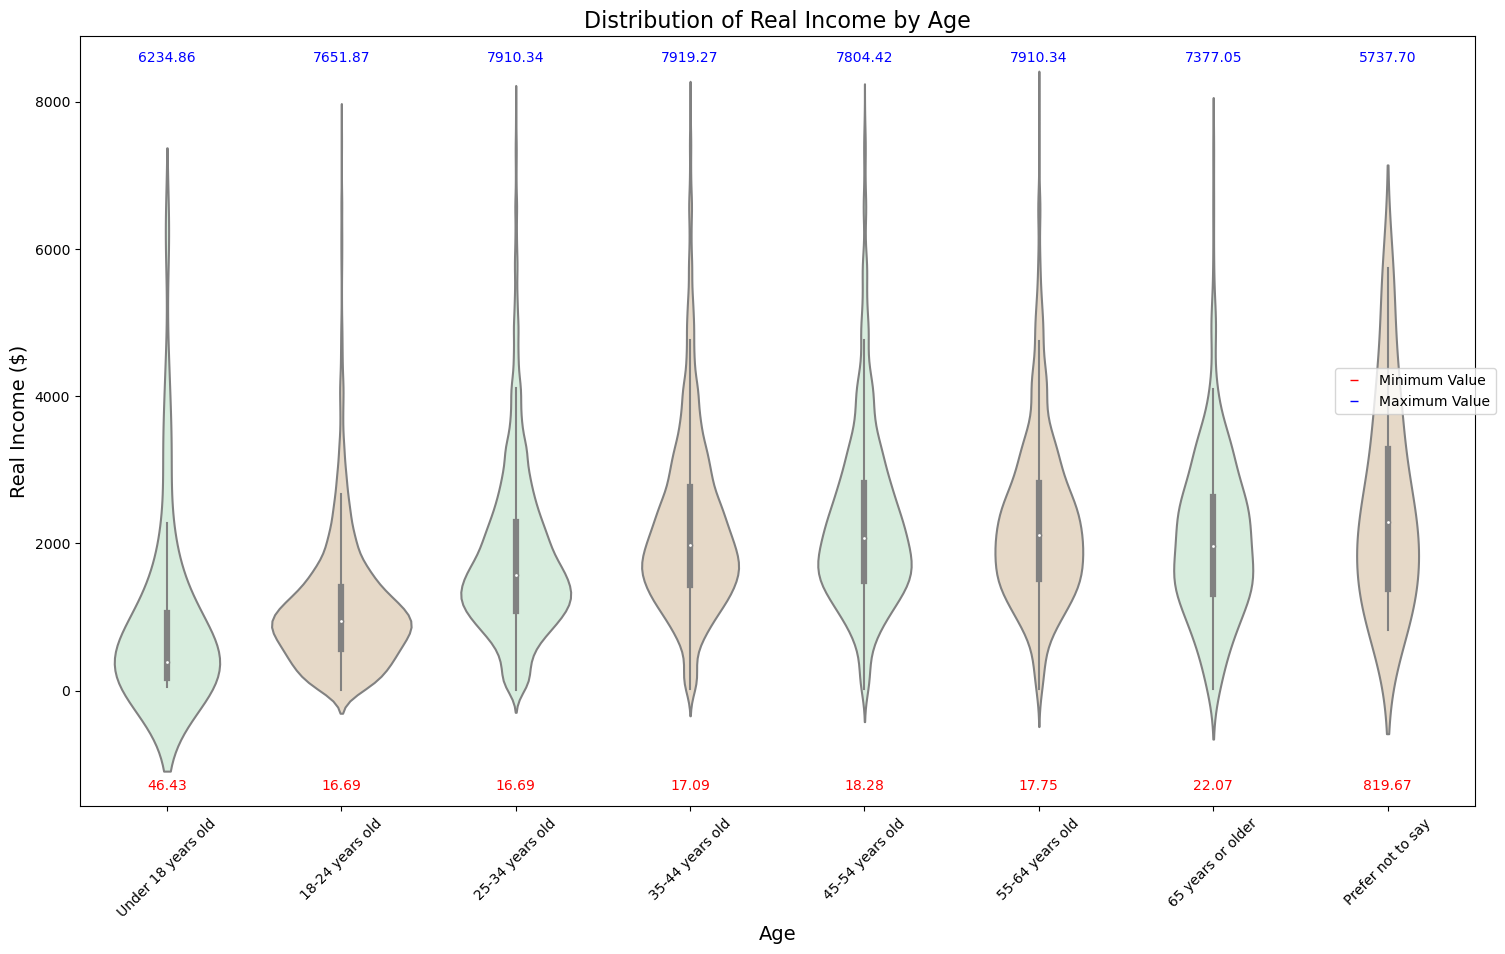

[396.594210597382,
 953.4250707146597,
 1567.1320287004883,
 1976.9134381541996,
 2067.770668940758,
 2111.805932655039,
 1967.2131147540983,
 2295.0819672131147]

In [20]:
age_buckets = ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old',
               '45-54 years old', '55-64 years old', '65 years or older', 'Prefer not to say']

plt.figure(figsize=(18, 10))
cmap = ["#d5f0dc", "#ebdac3", "#d5f0dc", "#ebdac3", "#d5f0dc", "#ebdac3", "#d5f0dc", "#ebdac3"]
ax = sns.violinplot(x="Age", y="RealIncome", data=df, order=age_buckets, palette=cmap)

min_vals = []
max_vals = []
medain_vals = []
for age in age_buckets:
    min_vals.append(df.groupby("Age").get_group(age).RealIncome.min())
    max_vals.append(df.groupby("Age").get_group(age).RealIncome.max())
    medain_vals.append(df.groupby("Age").get_group(age).RealIncome.median()) 
x_coords = np.arange(len(min_vals))

for i, (min_val, max_val) in enumerate(zip(min_vals, max_vals)):
    ax.text(x_coords[i], -1200, f"{min_val:.2f}", ha='center', va='top', fontsize=10, color='r')
    ax.text(x_coords[i], 8500, f"{max_val:.2f}", ha='center', va='bottom', fontsize=10, color='b')

# Add legend for min-max values
min_label = plt.Line2D([], [], color='r', marker='_', linestyle='None', label='Minimum Value')
max_label = plt.Line2D([], [], color='b', marker='_', linestyle='None', label='Maximum Value')
plt.legend(handles=[min_label, max_label], loc='lower right', bbox_to_anchor=(1.02, 0.5))

plt.title("Distribution of Real Income by Age", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Real Income ($)", fontsize=14)
plt.xticks(rotation=45)
plt.show()
medain_vals

In [21]:
df[df.Age == "18-24 years old"].shape

(4817, 34)

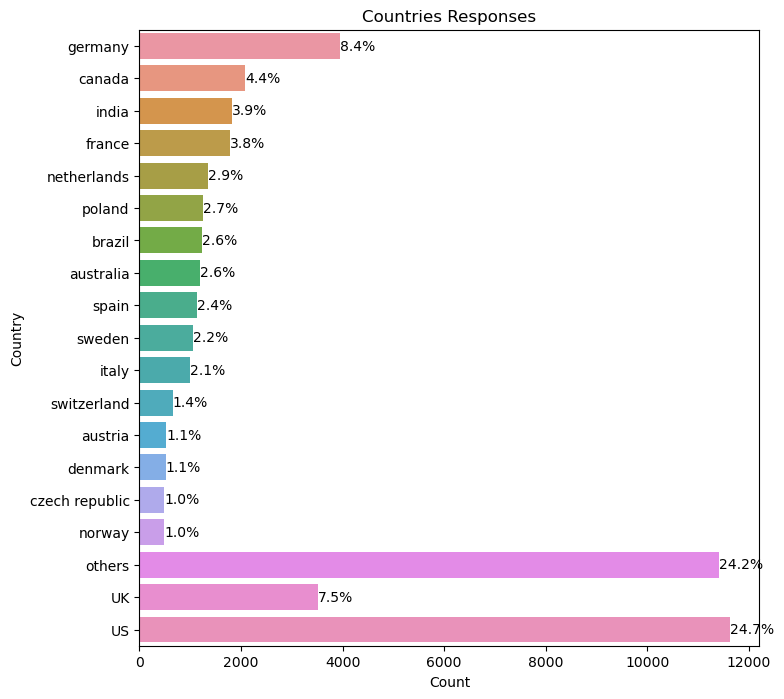

In [22]:
# Merge countries with less than 1% of respondents into others for plotting
threshold = 0.01 * 48000
countries = {}
others = 0

for key, value in df["Country"].value_counts().items():
    if value >= threshold:
        countries[key] = value
    else:
        others += value

countries["others"] = others
countries["UK"] = countries.pop("united kingdom of great britain and northern ireland", 0)
countries["US"] = countries.pop("united states of america", 0)

countries_df = pd.DataFrame({'Country': list(countries.keys()), 'Count': list(countries.values())})

plt.figure(figsize=(8, 8))
barplot = sns.barplot(x='Count', y='Country', data=countries_df)

plt.title('Countries Responses')
plt.xlabel('Count')
plt.ylabel('Country')

total_responses = countries_df['Count'].sum()
for index, row in countries_df.iterrows():
    percentage = row['Count'] / total_responses * 100
    plt.text(row['Count'], index, f'{percentage:.1f}%', va='center')

plt.show()

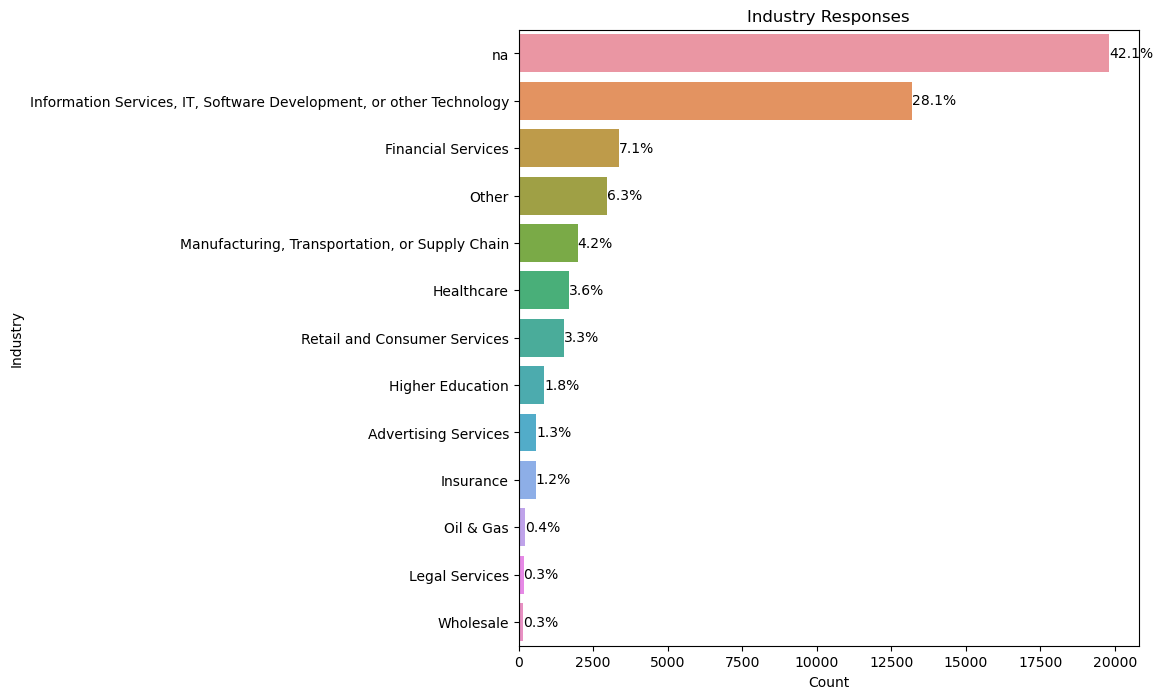

In [23]:
# Merge countries with less than 1% of respondents into others for plotting
threshold = 0 * 48000
countries = {}
others = 0

for key, value in df["Industry"].value_counts().items():
    if value >= threshold:
        countries[key] = value
    else:
        others += value


countries_df = pd.DataFrame({'Industry': list(countries.keys()), 'Count': list(countries.values())})

plt.figure(figsize=(8, 8))
barplot = sns.barplot(x='Count', y='Industry', data=countries_df)

plt.title('Industry Responses')
plt.xlabel('Count')
plt.ylabel('Industry')

total_responses = countries_df['Count'].sum()
for index, row in countries_df.iterrows():
    percentage = row['Count'] / total_responses * 100
    plt.text(row['Count'], index, f'{percentage:.1f}%', va='center')

plt.show()

## What Education Level are related with better equitable salary ?

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bachelor's degree
[1746.5253517699548]
Master’s degree
[1746.5253517699548, 1747.2193788814434]
Incomplete college/univ. study
[1746.5253517699548, 1747.2193788814434, 1599.2649753914109]
Professional degree
[1746.5253517699548, 1747.2193788814434, 1599.2649753914109, 1752.5676550771436]
Secondary school
[1746.5253517699548, 1747.2193788814434, 1599.2649753914109, 1752.5676550771436, 1324.202673587244]
Associate degree
[1746.5253517699548, 1747.2193788814434, 1599.2649753914109, 1752.5676550771436, 1324.202673587244, 1511.2184651963578]
Something else
[1746.5253517699548, 1747.2193788814434, 1599.2649753914109, 1752.5676550771436, 1324.202673587244, 1511.2184651963578, 1271.005665542318]
Primary/elementary school
[1746.5253517699548, 1747.2193788814434, 1599.2649753914109, 1752.5676550771436, 1324.202673587244, 1511.2184651963578, 1271.005665542318, 1511.2184651963578]


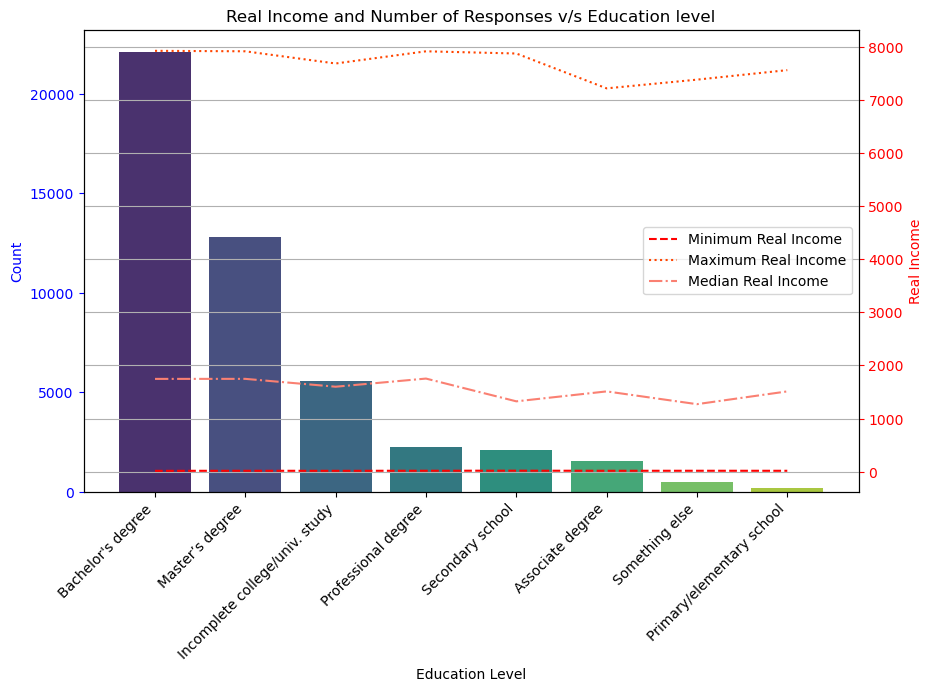

([7919.272247456397,
  7910.3419188989055,
  7681.016393442623,
  7910.3419188989055,
  7868.852459016393,
  7213.11475409836,
  7377.049180327869,
  7556.092325981788],
 ["Bachelor's degree",
  'Master’s degree',
  'Incomplete college/univ. study',
  'Professional degree',
  'Secondary school',
  'Associate degree',
  'Something else',
  'Primary/elementary school'])

In [24]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

x = list(df.EdLevel.value_counts().index)
bar_data = df.EdLevel.value_counts()

min_vals = []
max_vals = []
median_vals = []

for degree in x:
    print(degree)
    min_vals.append(df.groupby("EdLevel").get_group(degree).RealIncome.min())
    max_vals.append(df.groupby("EdLevel").get_group(degree).RealIncome.max())
    median_vals.append(df.groupby("EdLevel").get_group(degree).RealIncome.median())
    print(median_vals)

ax1 = sns.barplot(x=x, y=bar_data, palette='viridis', ax=ax1)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_xlabel('Education Level')
ax1.set_ylabel('Count', color='b')

legend = ax2.legend(loc=(20, 40), fontsize='small')


ax2.plot(x, min_vals, color='red', label='Minimum Real Income',linestyle='--')
ax2.plot(x, max_vals, color='orangered', label='Maximum Real Income',linestyle='dotted')
ax2.plot(x, median_vals, color='salmon', label='Median Real Income',linestyle='dashdot')

ax2.set_ylabel('Real Income', color='r')

ax2.legend(loc='center right')

ax1.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')
plt.grid(True)
plt.title('Real Income and Number of Responses v/s Education level')
plt.show()

max_vals, x

In [25]:
edLevel = df.groupby('EdLevel')['RealIncome'].agg(['min', 'median', 'max', 'count', 'mean', np.std])
printStats(edLevel, "education level", 3)
edLevel = edLevel.round(decimals=2)

1. Top 3 education level paying maximum equitable salary on average:

                                count         mean
EdLevel                                           
Professional degree              2233  2009.942826
Master’s degree                 12805  2000.652955
Bachelor's degree               22101  1958.870428
Incomplete college/univ. study   5547  1824.031761
Associate degree                 1572  1702.107926

2. Top 3 education level paying worst equitable salaries on average:

                                count         mean
EdLevel                                           
Something else                    477  1428.406635
Secondary school                 2122  1533.793567
Primary/elementary school         205  1690.613851
Associate degree                 1572  1702.107926
Incomplete college/univ. study   5547  1824.031761
3. Top 3 education level paying worst minimum equitable salaries:

                                count        min
EdLevel                      

/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/714036501.py:1: FutureWarning: The provided callable <function std at 0x10743a700> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  edLevel = df.groupby('EdLevel')['RealIncome'].agg(['min', 'median', 'max', 'count', 'mean', np.std])


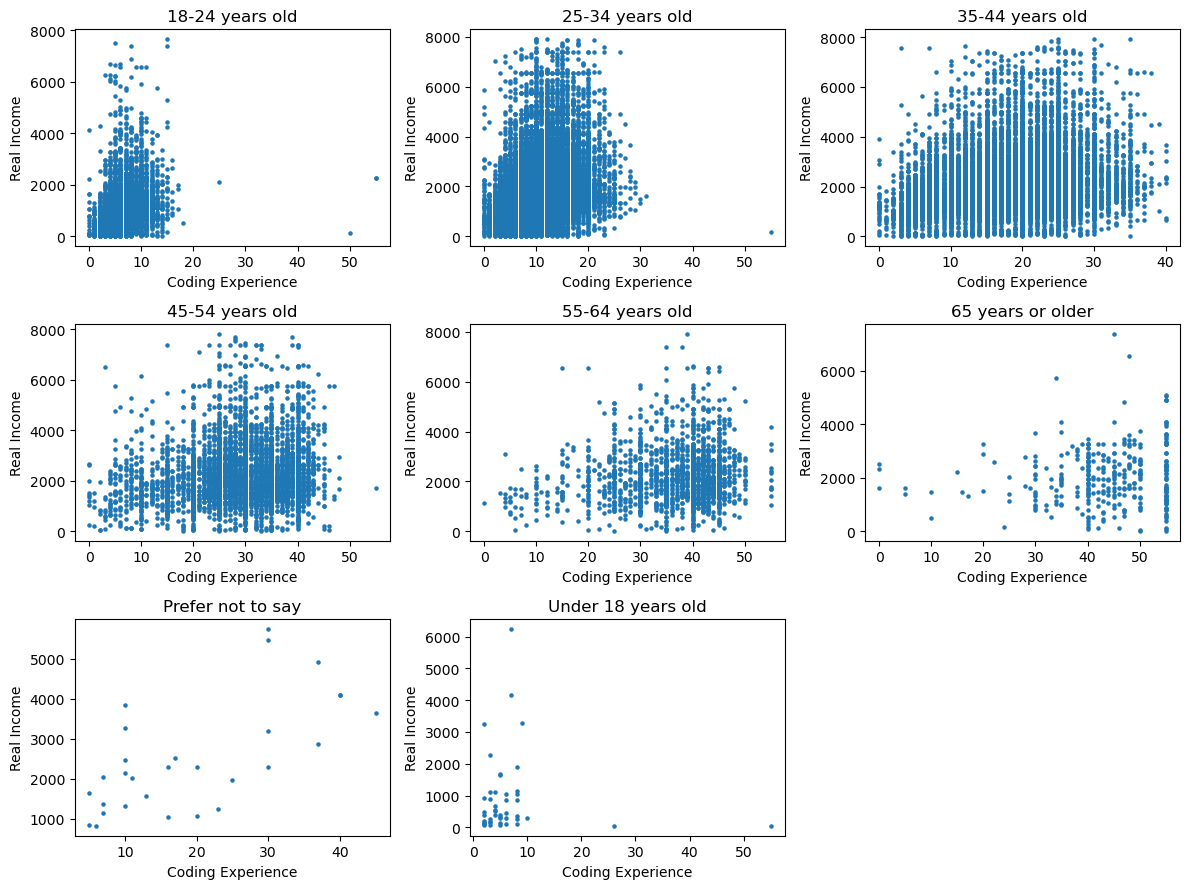

In [26]:
age_groups = df.groupby('Age')

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
axes = axes.ravel()

for i, (age_group, group) in enumerate(age_groups):
    if i < 9:
        ax = axes[i]
        ax.scatter(group['YearsCode'], group['RealIncome'], s=5)
        ax.set_title(age_group)
        ax.set_xlabel('Coding Experience')
        ax.set_ylabel('Real Income')

fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

## Which job roles are paying more equitable salary ?

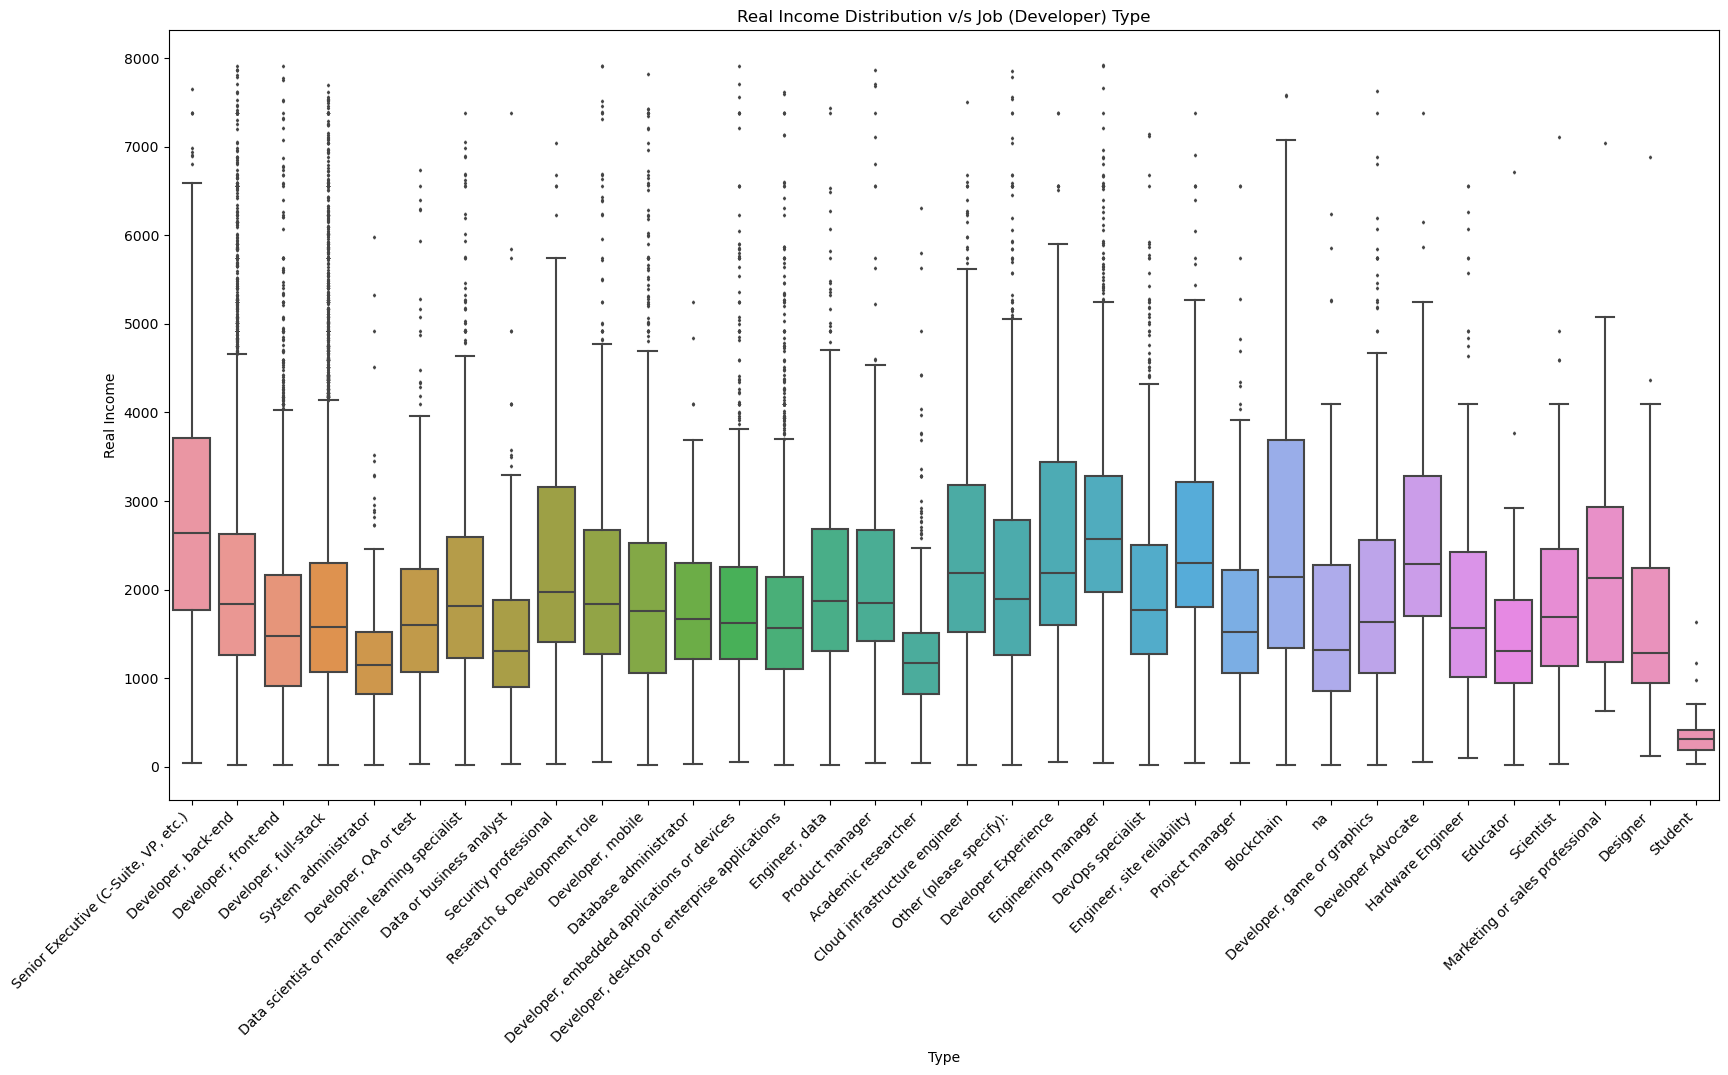

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='DevType', y='RealIncome', data=df, ax=ax, fliersize=1.5)  # Increase the size of outlier dots
ax.set_xlabel('Type')
ax.set_ylabel('Real Income')
ax.set_title('Real Income Distribution v/s Job (Developer) Type')
plt.xticks(rotation=45, ha='right')
plt.show()

In [28]:
jobType = df.groupby('DevType')['RealIncome'].agg(['min', 'median', 'max', 'count', 'mean', np.std])
printStats(jobType, "job roles")

1. Top 5 job roles paying maximum equitable salary on average:

                                      count         mean
DevType                                                 
Senior Executive (C-Suite, VP, etc.)    728  2884.220114
Engineering manager                    1277  2752.860192
Blockchain                              177  2592.199080
Developer Experience                    213  2572.287386
Engineer, site reliability              312  2562.060716

2. Top 5 job roles paying worst equitable salaries on average:

                          count         mean
DevType                                     
Student                      21   425.205049
System administrator        323  1253.634080
Academic researcher         603  1269.177176
Educator                    152  1410.086193
Data or business analyst    443  1460.811673
3. Top 5 job roles paying worst minimum equitable salaries:

                         count        min
DevType                                  
Developer, m

/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/3142292583.py:1: FutureWarning: The provided callable <function std at 0x10743a700> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  jobType = df.groupby('DevType')['RealIncome'].agg(['min', 'median', 'max', 'count', 'mean', np.std])


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


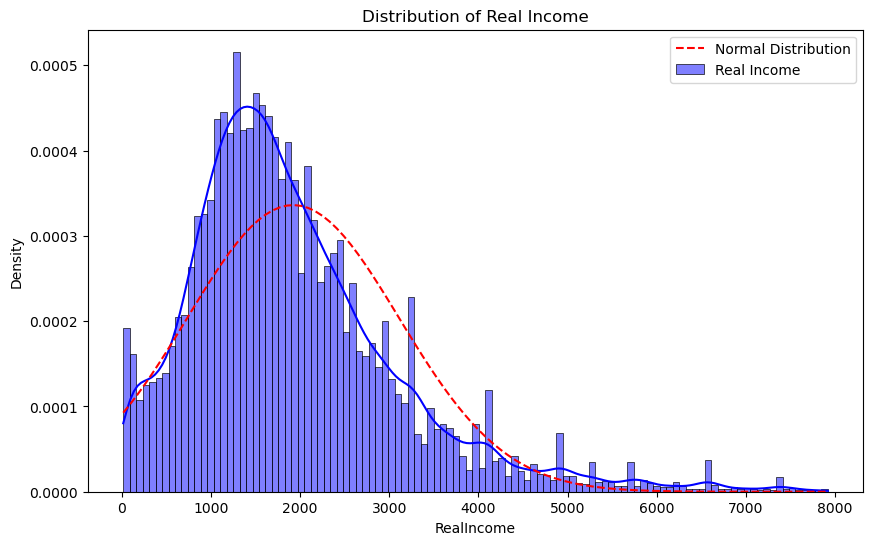

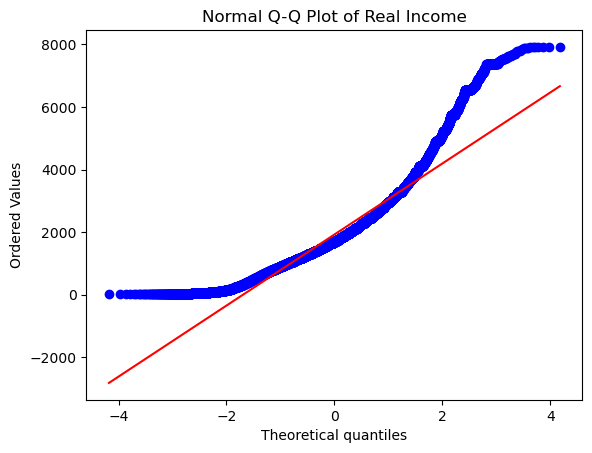

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df['RealIncome'], kde=True, stat='density', color='blue', label = "Real Income")

mean = df['RealIncome'].mean()
std = df['RealIncome'].std()
x = np.linspace(df['RealIncome'].min(), df['RealIncome'].max(), 100)
normal_dist = stats.norm.pdf(x, mean, std)
plt.plot(x, normal_dist, '--r', label='Normal Distribution')
plt.title('Distribution of Real Income')
plt.legend()
plt.show()

stats.probplot(df['RealIncome'], plot=plt)
plt.title('Normal Q-Q Plot of Real Income')
plt.show()

## Which countries are paying more equitable salary

/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/1190139726.py:1: FutureWarning: The provided callable <function std at 0x10743a700> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  country_stats = df.groupby('Country')['RealIncome'].agg(['min', 'median', 'max', 'count', 'mean', np.std])
/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/1190139726.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(filtered_countries['Country'], rotation=90)  # Remove the x-axis tick labels


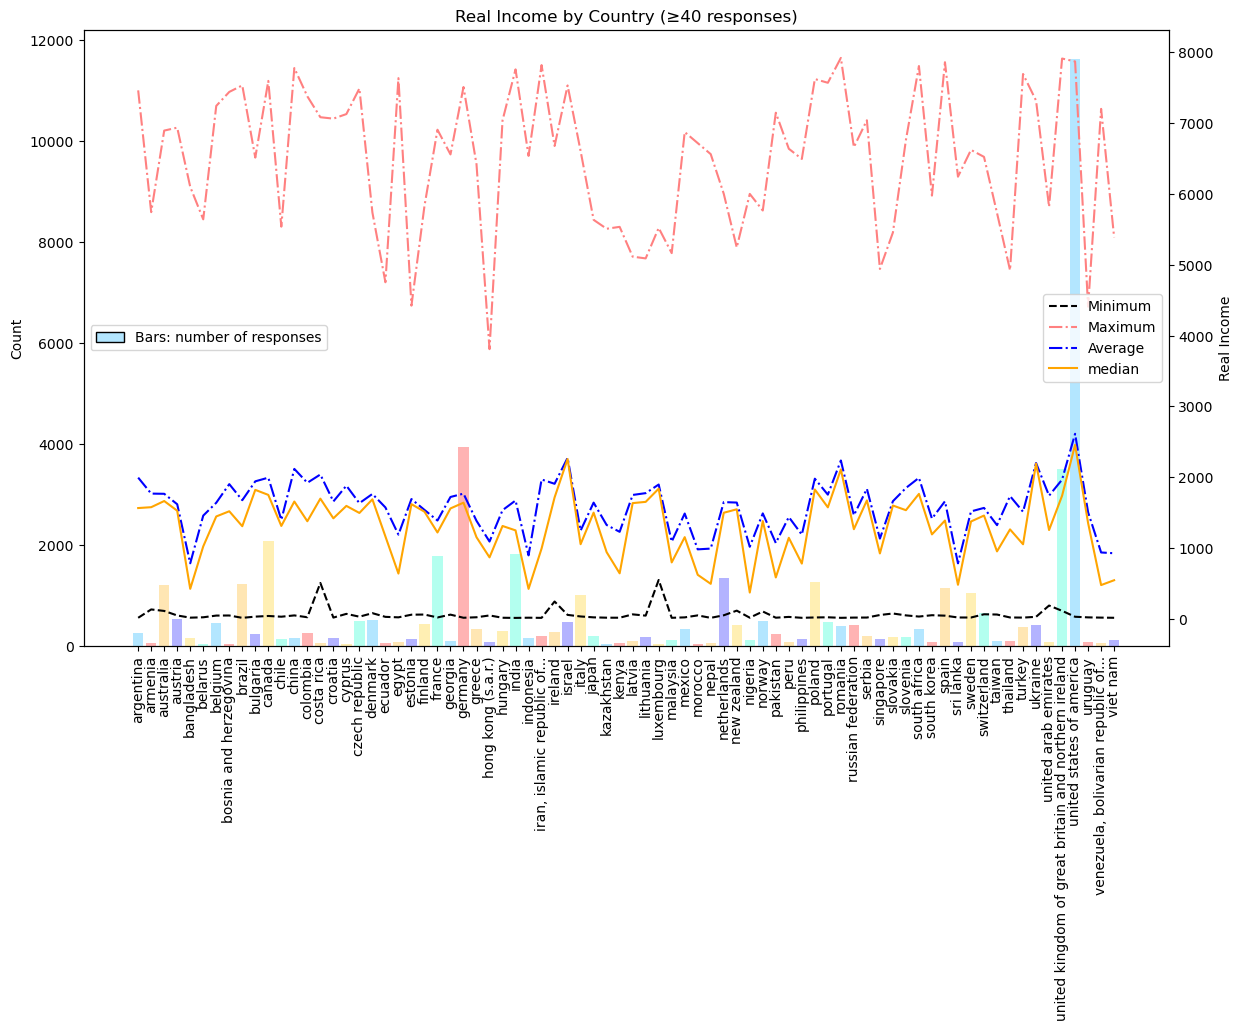

In [30]:
country_stats = df.groupby('Country')['RealIncome'].agg(['min', 'median', 'max', 'count', 'mean', np.std])
filtered_countries = country_stats[country_stats['count'] >= 40].reset_index()

fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()
colors = ['#b3e6ff', '#ffb3b3', '#ffe6b3', '#b3b3ff', '#ffefb3', '#b3ffef']
for i, country in enumerate(filtered_countries['Country']):
    color = colors[i % len(colors)]
    ax1.bar(country, filtered_countries.loc[i, 'count'], color=color)

ax2.plot(filtered_countries['Country'], filtered_countries['min'], color='black', linestyle='--', label='Minimum')
ax2.plot(filtered_countries['Country'], filtered_countries['max'], color='#ff8080', linestyle='dashdot', label='Maximum')
ax2.plot(filtered_countries['Country'], filtered_countries['mean'], color='blue', linestyle='dashdot', label='Average')
ax2.plot(filtered_countries['Country'], filtered_countries['median'], color='orange', label='median')
ax1.set_xticklabels(filtered_countries['Country'], rotation=90)  # Remove the x-axis tick labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Real Income')
plt.title('Real Income by Country (≥40 responses)')
ax2.legend(loc='center right')

bar_patch = mpatches.Patch(facecolor=colors[0], edgecolor='black', label='Bars: number of responses')
ax1.legend(handles=[bar_patch], loc='center left')

plt.show()

## Which skills are related to which job roles

In [31]:
def createHeatMap(df,col1,col2):
    df_copy = df.copy()
    
    threshold = 0.01 * 48000
    
    df_copy['Skills'] = df_copy[col2].str.split(';')
    pivot_table = pd.pivot_table(df_copy.explode('Skills'), index=col1, columns='Skills', aggfunc='size', fill_value=0)
    pivot_table = pivot_table.loc[:, (pivot_table.sum() >= threshold)]
    pivot_table['Others'] = pivot_table.sum(axis=1) - pivot_table.sum(axis=1, numeric_only=True)
    pivot_table = pivot_table.loc[:, (pivot_table.sum(axis=0) >= threshold)]
    pivot_table = pivot_table.drop(pivot_table.index[pivot_table.index == 'na'])
    pivot_table = pivot_table.drop(pivot_table.columns[pivot_table.columns == 'na'], axis=1)

    pivot_table = pivot_table.dropna(how='all', subset=pivot_table.columns[:-1])  
    pivot_table = pivot_table.dropna(how='all', axis=1) 
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=False, cmap="YlGnBu")
    plt.title(f'Heatmap: {col1} vs {col2} Skills')
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.show()

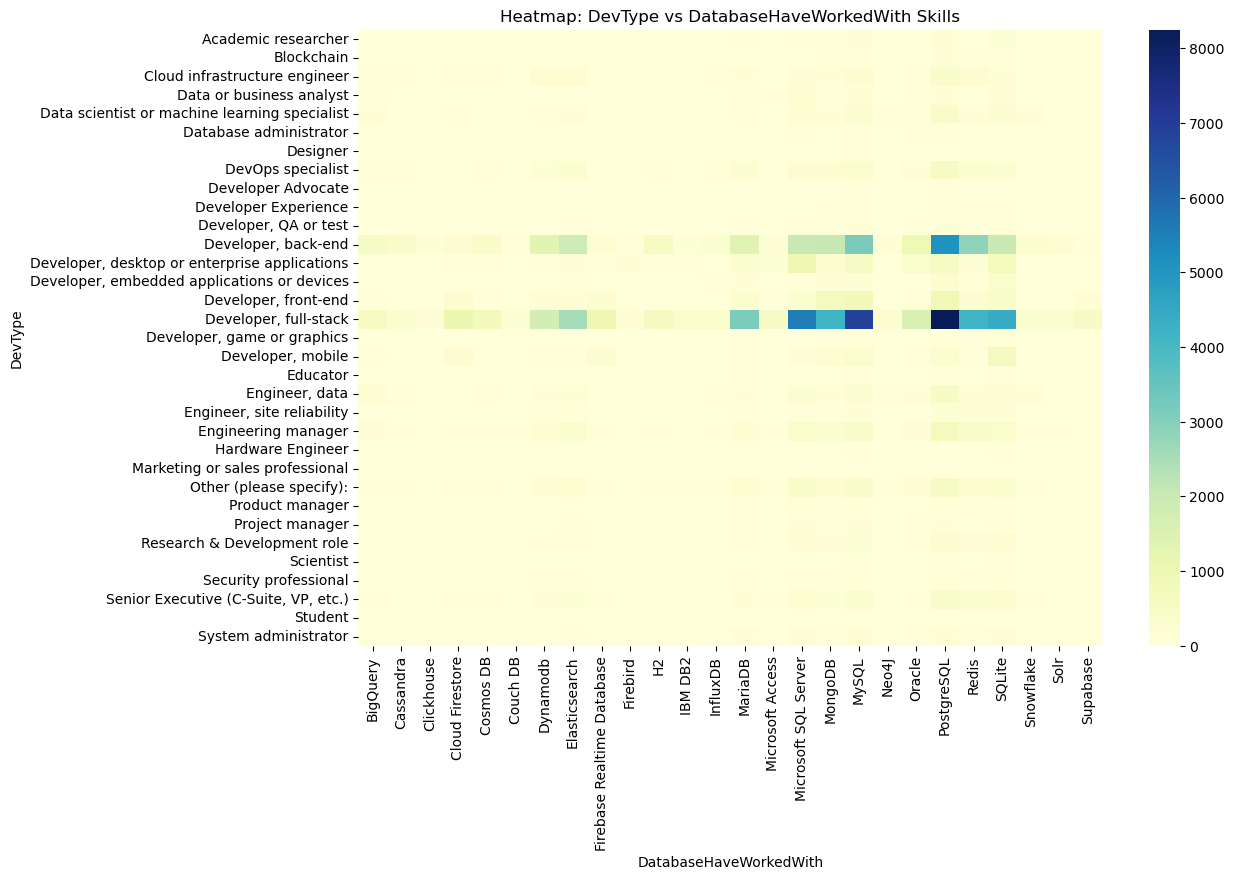

In [32]:
createHeatMap(df,"DevType","DatabaseHaveWorkedWith")

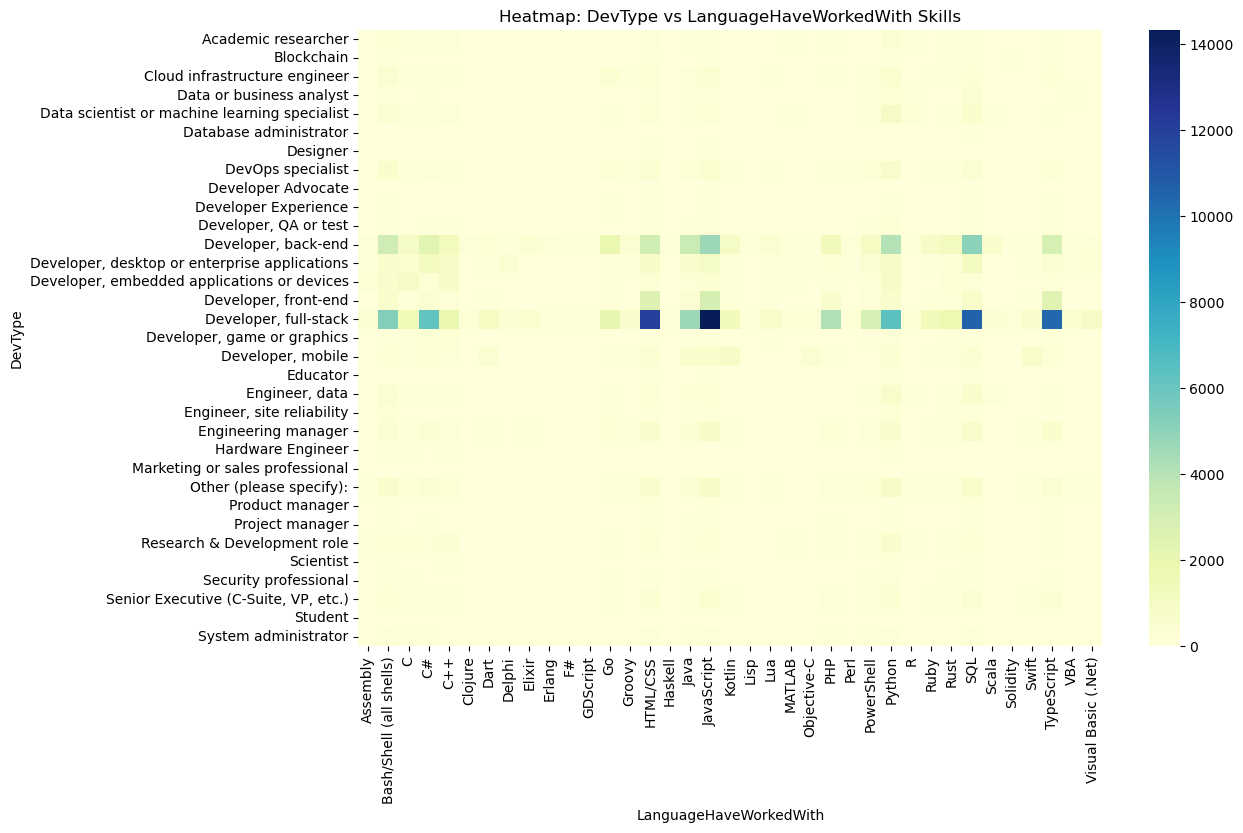

In [33]:
createHeatMap(df,"DevType","LanguageHaveWorkedWith")

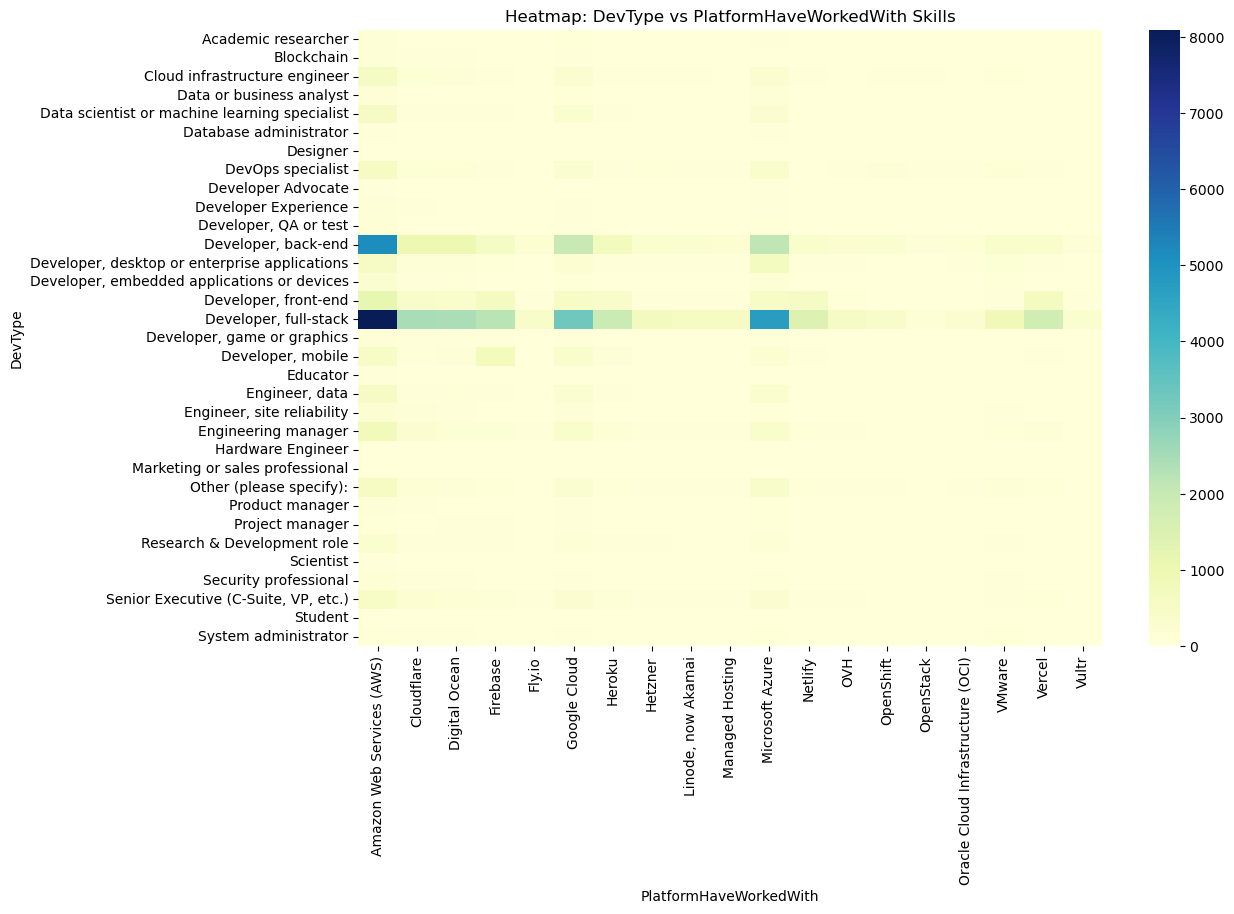

In [34]:
createHeatMap(df,"DevType","PlatformHaveWorkedWith")

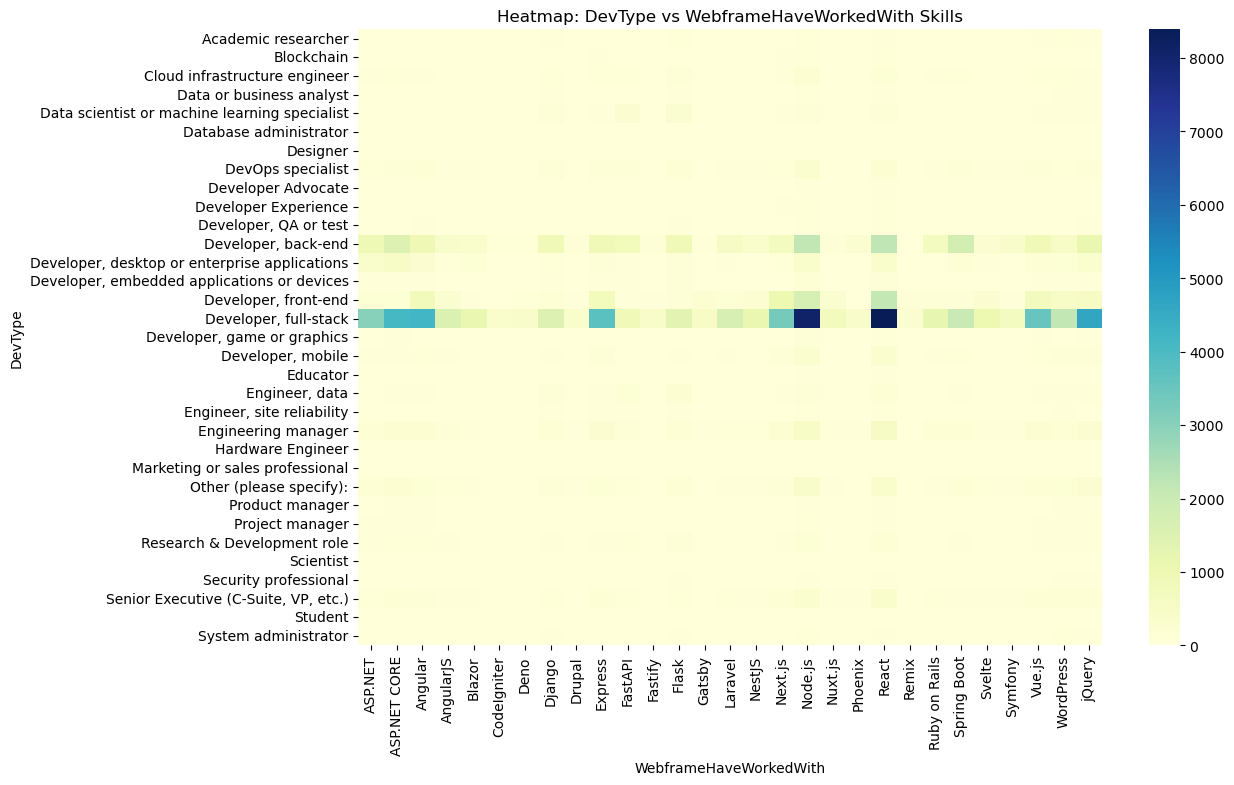

In [35]:
createHeatMap(df,"DevType","WebframeHaveWorkedWith")

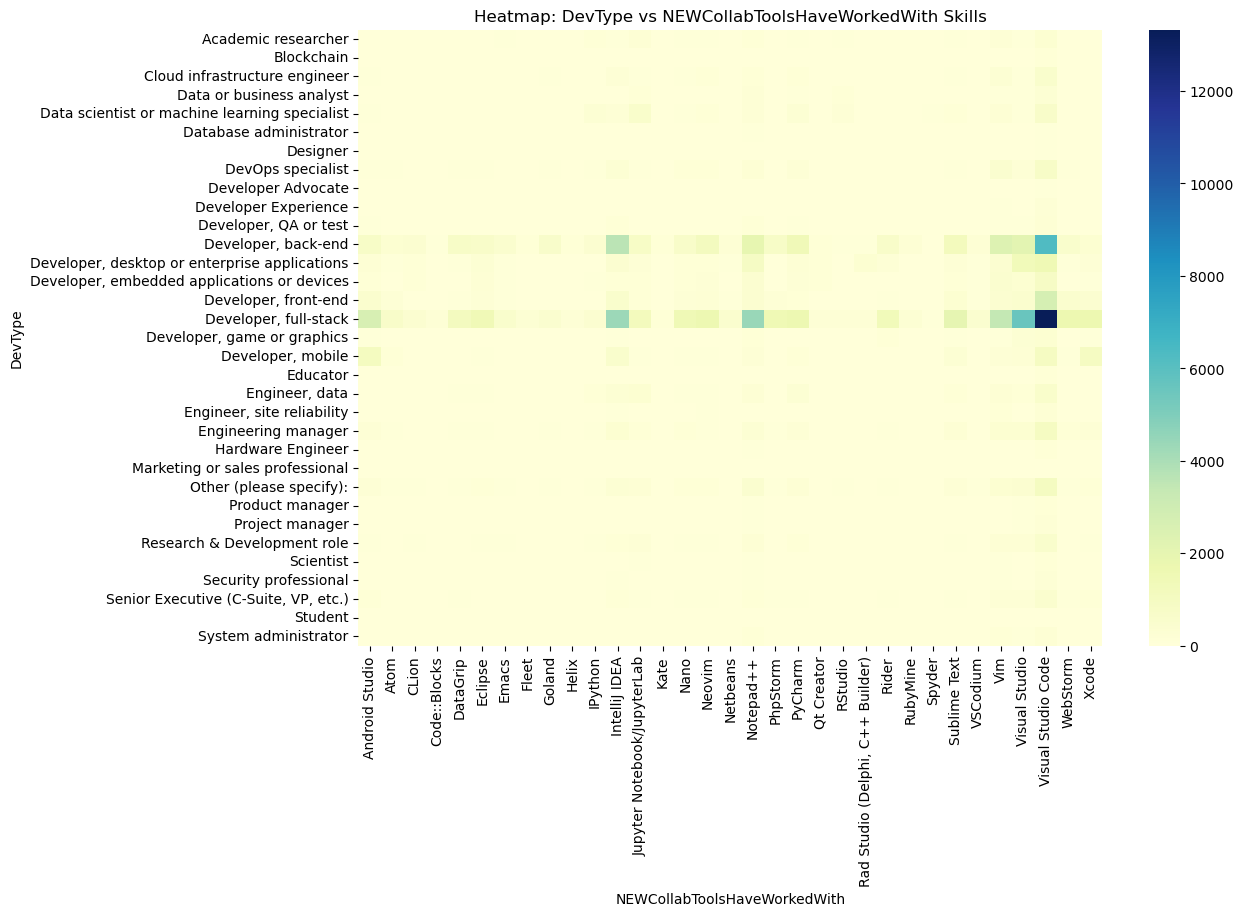

In [36]:
createHeatMap(df,"DevType","NEWCollabToolsHaveWorkedWith")

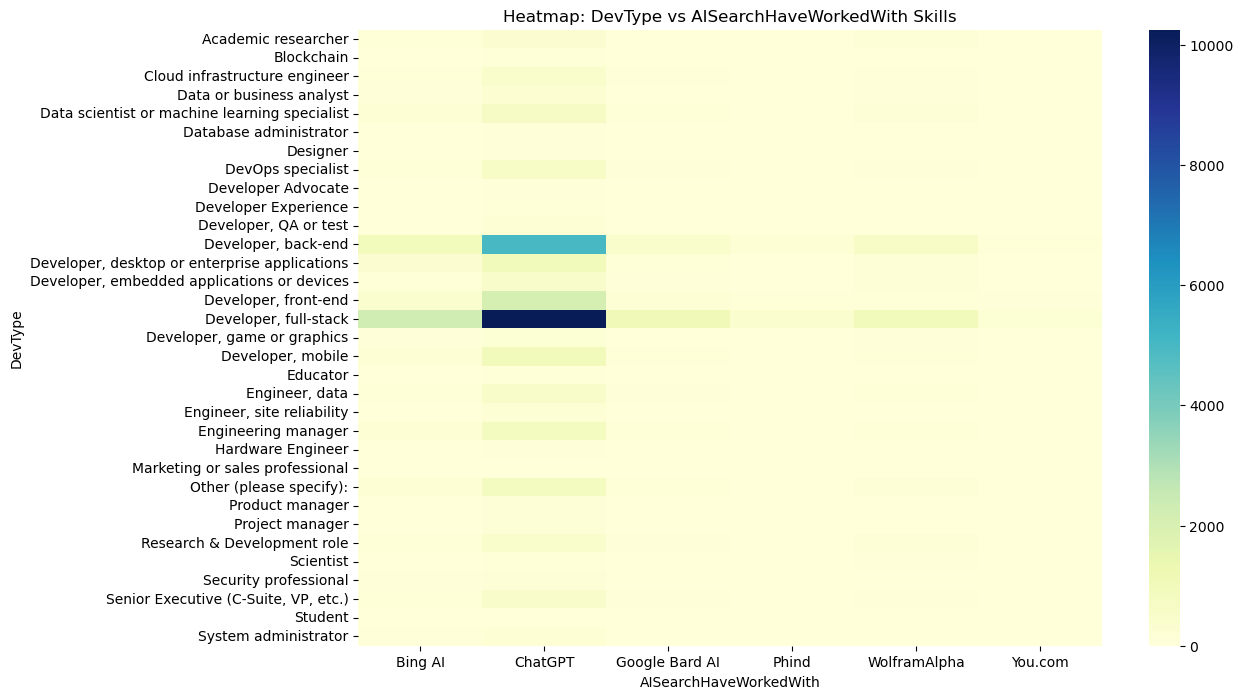

In [37]:
createHeatMap(df,"DevType","AISearchHaveWorkedWith")

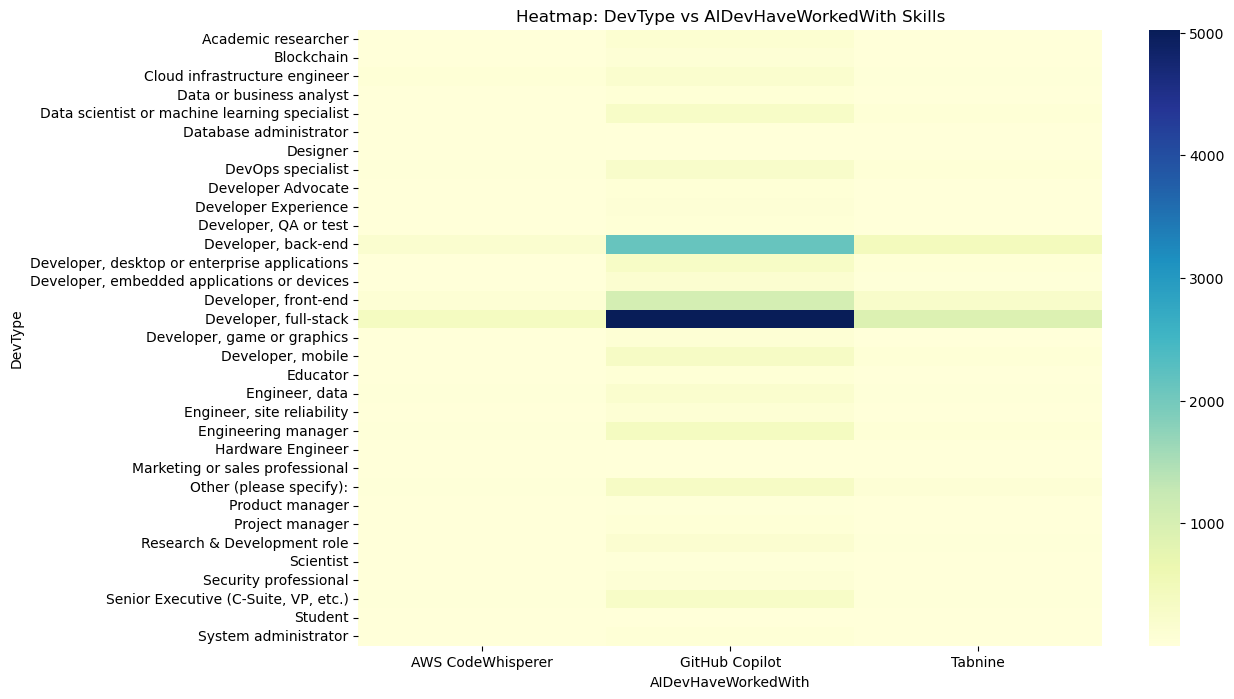

In [38]:
createHeatMap(df,"DevType","AIDevHaveWorkedWith")

# Hypothesis testing

In [39]:
alpha = 0.05

## Do people with AI skills get paid more ?
### H0: There is no significant difference in the mean real adjusted income (adjusted for cost of living) between people with AI skills and those without AI skills.
### H1: People with AI skills have a higher mean real adjusted income (adjusted for cost of living) than those without AI skills.

##### Check Normality to decide if parametric (t-test) or non paramteric (mann whitney u-test) needs to be conducted

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


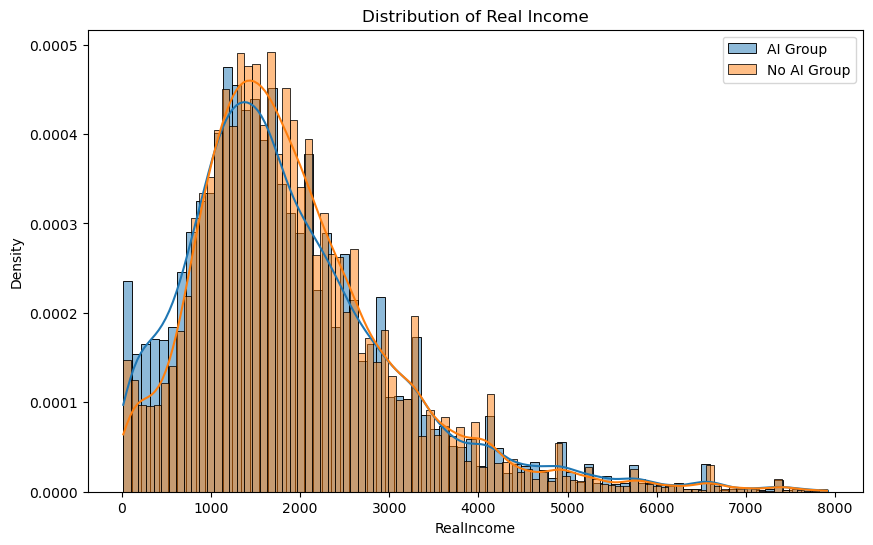

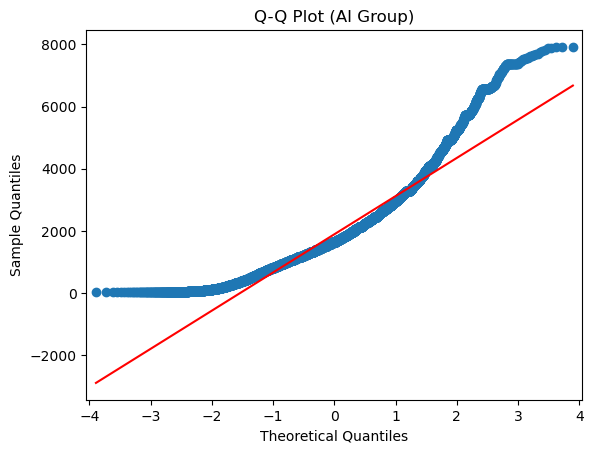

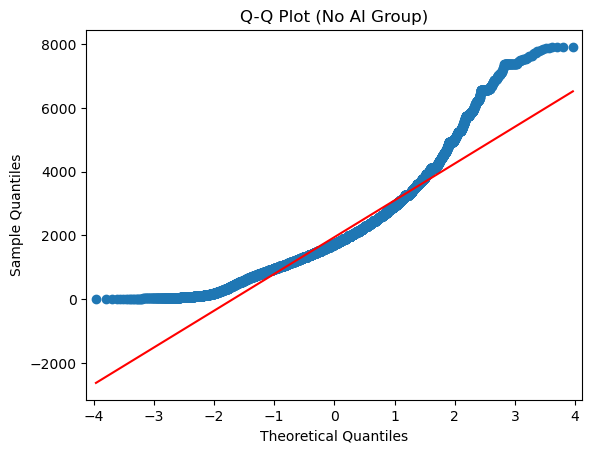

Levene's Test Statistic: 59.3840
p-value: 0.0000
The variances are significantly different (unequal variances).


In [40]:
df['has_ai_skills'] = df['AISelect'].apply(lambda x: True if x == "Yes" else False)

plt.figure(figsize=(10, 6))
sns.histplot(df[df['has_ai_skills']]['RealIncome'], kde=True, stat='density', label='AI Group')
sns.histplot(df[~df['has_ai_skills']]['RealIncome'], kde=True, stat='density', label='No AI Group')
plt.title('Distribution of Real Income')
plt.legend()
plt.show()

sm.qqplot(df[df['has_ai_skills']]['RealIncome'], line='s')
plt.title('Q-Q Plot (AI Group)')
plt.show()

sm.qqplot(df[~df['has_ai_skills']]['RealIncome'], line='s')
plt.title('Q-Q Plot (No AI Group)')
plt.show()

ai_income = df[df['has_ai_skills']]['RealIncome']
no_ai_income = df[~df['has_ai_skills']]['RealIncome']

statistic, p_value = levene(ai_income, no_ai_income)

print(f"Levene's Test Statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print(Fore.RED + "The variances are significantly different (unequal variances).")
else:
    print(Fore.GREEN + "There is no evidence of unequal variances.")


In [41]:
u_stat, p_value = mannwhitneyu(ai_income, no_ai_income, alternative='greater')
print(f"U-statistic: {u_stat}, p-value: {p_value:.4f}")

if p_value < alpha:
    print(Fore.GREEN + "Reject the null hypothesis. People with AI skills have a higher mean real adjusted income.")
else:
    print(Fore.RED + "Fail to reject the null hypothesis. The data does not provide enough evidence to support the claim that people with AI skills have a higher mean real adjusted income.")

print(Style.RESET_ALL)

U-statistic: 259128496.0, p-value: 1.0000
Fail to reject the null hypothesis. The data does not provide enough evidence to support the claim that people with AI skills have a higher mean real adjusted income.



## Do people with more years of professional coding experience have higher real income ?
### H0: The number of years of professional coding experience has no impact on the real income of developers.
### H1: Developers with more years of professional coding experience tend to have higher real incomes compared to those with fewer years of experience.

In [42]:
corr_coef, p_value = pearsonr(df['YearsCodePro'], df['RealIncome'])
print(f'Pearson Correlation Coefficient: {corr_coef:.4f}, p-value: {p_value:.4f}')

X = sm.add_constant(df['YearsCodePro'])
y = df['RealIncome']

model = sm.OLS(y, X).fit()
print(model.summary())

if model.pvalues['YearsCodePro'] < alpha:
    print(Fore.GREEN + 'Reject the null hypothesis. Developers with more years of coding experience tend to have higher real incomes.')
else:
    print(Fore.RED + 'Fail to reject the null hypothesis. The data does not provide enough evidence to support the claim that developers with more years of coding experience have higher real incomes.')

Pearson Correlation Coefficient: 0.3089, p-value: 0.0000
                            OLS Regression Results                            
Dep. Variable:             RealIncome   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4964.
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        14:02:25   Log-Likelihood:            -3.9758e+05
No. Observations:               47062   AIC:                         7.952e+05
Df Residuals:                   47060   BIC:                         7.952e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

## Does geographic location imapcts your potential to earn ?
### H0: The real income of developers is not related to their geographic location or the currency they use day-to-day. 
### H1: There are significant differences in the real income of developers based on their geographic location and the currency they use day-to-day, accounting for variations in the cost of living.

                            OLS Regression Results                            
Dep. Variable:             RealIncome   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     46.16
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        14:02:26   Log-Likelihood:            -3.9485e+05
No. Observations:               47062   AIC:                         7.902e+05
Df Residuals:                   46816   BIC:                         7.924e+05
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

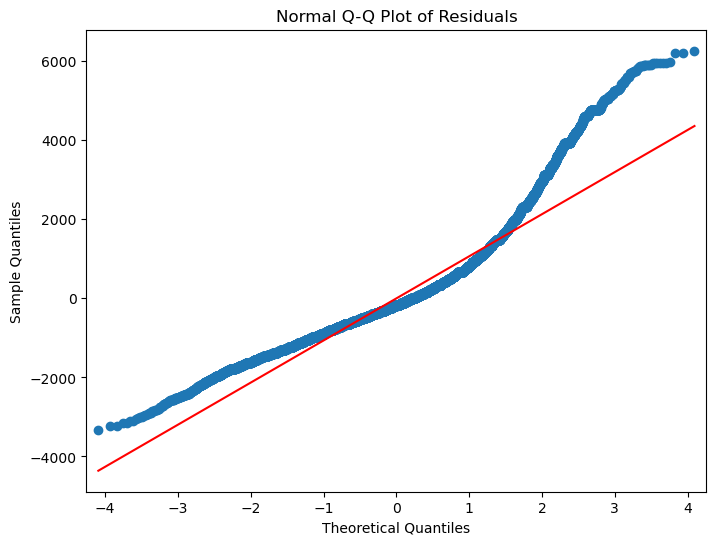

Levene's test for 'Country': p-value = 0.0
Levene's test for 'Currency': p-value = 0.0
Perform non paramteric kruskal tests instead of Anova


In [43]:
df['Country'] = pd.Categorical(df['Country'], categories=df['Country'].unique())
df['Currency'] = pd.Categorical(df['Currency'], categories=df['Currency'].unique())

model = smf.ols('RealIncome ~ C(Country) + C(Currency)', data=df).fit()

print(model.summary())

residuals = model.resid

fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('Normal Q-Q Plot of Residuals')
plt.show()

df['Country_num'] = pd.factorize(df['Country'])[0]
df['Currency_num'] = pd.factorize(df['Currency'])[0]

levene_country = levene(df['RealIncome'], df['Country_num'])
print(f"Levene's test for 'Country': p-value = {levene_country.pvalue}")

levene_currency = levene(df['RealIncome'], df['Currency_num'])
print(f"Levene's test for 'Currency': p-value = {levene_currency.pvalue}")

if float(levene_country.pvalue) < alpha or float(levene_currency.pvalue) < alpha:
    print(Fore.RED + 'Perform non paramteric kruskal tests instead of Anova')
else:
    print(Fore.GREEN + 'Results of anova are valid')


In [44]:
df['Country'] = pd.Categorical(df['Country'], categories=df['Country'].unique())
df['Currency'] = pd.Categorical(df['Currency'], categories=df['Currency'].unique())
df['Country_Currency'] = df['Country'].astype(str) + '_' + df['Currency'].astype(str)
df['Country_Currency_num'] = pd.factorize(df['Country_Currency'])[0]
levene_country = levene(df['RealIncome'], df['Country_Currency_num'])
print(levene_country)
kruskal_country_currency = kruskal(*[group['RealIncome'].values for name, group in df.groupby('Country_Currency')])
p_value_country_currency = kruskal_country_currency.pvalue
print(p_value_country_currency)
if p_value_country_currency < alpha:
    print(Fore.GREEN + "Conclusion: The null hypothesis can be rejected.")
    print(Fore.GREEN + "There are significant differences in the median real income of developers based on their geographic location and the currency they use day-to-day.")
else:
    print(Fore.RED + "Conclusion: The null hypothesis cannot be rejected.")
    print(Fore.RED + "The median real income of developers is not related to their geographic location and the currency they use day-to-day.")
kruskal_country_currency

LeveneResult(statistic=46077.4296856029, pvalue=0.0)
0.0
Conclusion: The null hypothesis can be rejected.
There are significant differences in the median real income of developers based on their geographic location and the currency they use day-to-day.


KruskalResult(statistic=11514.96035595381, pvalue=0.0)

## Does your education level directly influence how much you can potentially earn?
### H0: There is no significant difference in the real income of developers across different levels of formal education attainment.
### H1: The real income of developers varies significantly based on their highest level of formal education completed.


In [45]:
df['EdLevel'] = pd.Categorical(df['EdLevel'], categories=df['EdLevel'].unique())
df['EdLevel_num'] = pd.factorize(df['EdLevel'])[0]

l = levene(df['RealIncome'], df['EdLevel_num'])
print(l)
kruskal_edu = kruskal(*[group['RealIncome'].values for name, group in df.groupby('EdLevel')])

if float(kruskal_edu.pvalue) < alpha:
    print(Fore.GREEN + "\nConclusion: The null hypothesis can be rejected.")
    print(Fore.GREEN + "There is a significant difference in the real income of developers across different levels of formal education attainment.")
else:
    print(Fore.RED + "\nConclusion: The null hypothesis cannot be rejected.")
    print(Fore.RED + "There is no significant difference in the real income of developers across different levels of formal education attainment.")

print(Style.RESET_ALL)

LeveneResult(statistic=48775.57931205088, pvalue=0.0)

Conclusion: The null hypothesis can be rejected.
There is a significant difference in the real income of developers across different levels of formal education attainment.



/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/2974629261.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_edu = kruskal(*[group['RealIncome'].values for name, group in df.groupby('EdLevel')])


In [46]:
kruskal_edu

KruskalResult(statistic=668.0566362694838, pvalue=5.30248539561588e-140)

## The use of online courses or certifications for learning to code is independent of the developer's highest level of formal education.

### H0: The use of online courses or certifications for learning to code is independent of the developer's highest level of formal education.
### H1: The use of online courses or certifications for learning to code is not independent of (i.e., associated with) the developer's highest level of formal education.

In [47]:
import pandas as pd
from scipy import stats
from colorama import Fore

df_exploded = pd.DataFrame({'LearnCodeCoursesCert': df['LearnCodeCoursesCert'], 'EdLevel': df['EdLevel']})
df_exploded['LearnCodeCoursesCert'] = df['LearnCodeCoursesCert'].str.split(';')
df_exploded = df_exploded.explode('LearnCodeCoursesCert')

contingency_table = pd.crosstab(df_exploded['EdLevel'], df_exploded['LearnCodeCoursesCert'])
print("Contingency Table (Observed Frequencies):")
print(contingency_table)
print()

chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print("Expected Frequencies:")
expected_table = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print(expected_table)
print()

print("Row Totals (Observed):")
print(contingency_table.sum(axis=1))
print()

print("Column Totals (Observed):")
print(contingency_table.sum(axis=0))
print()

print(f"Chi-square statistic: {chi2_statistic:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

if p_value < alpha:
    print(Fore.GREEN + "Reject the null hypothesis. The use of online courses or certifications is associated with the developer's education level.")
else:
    print(Fore.RED + "Fail to reject the null hypothesis. There is no evidence of an association between the use of online courses or certifications and the developer's education level.")

Contingency Table (Observed Frequencies):
LearnCodeCoursesCert            Codecademy  Coursera  Other  Pluralsight  \
EdLevel                                                                    
Bachelor's degree                     2308      3104   1913         2951   
Incomplete college/univ. study         655       667    514          656   
Master’s degree                       1054      2211   1037         1450   
Professional degree                    159       401    174          121   
Associate degree                       215       175    169          223   
Secondary school                       207       146    153          181   
Primary/elementary school               17        18     18           11   
Something else                          60        48     57           54   

LearnCodeCoursesCert            Skillsoft  Udacity  Udemy   edX     na  
EdLevel                                                                 
Bachelor's degree                     141     1052 

In [48]:
expected_table['Row_Sum'] = expected_table.sum(axis=1)
column_sums = expected_table.sum(axis=0)
expected_table.loc['Column_Sums'] = column_sums
expected_table

LearnCodeCoursesCert,Codecademy,Coursera,Other,Pluralsight,Skillsoft,Udacity,Udemy,edX,na,Row_Sum
EdLevel,,,,,,,,,,
Bachelor's degree,2220.866963,3216.100393,1916.833838,2682.617270,152.016562,1031.812416,6494.907618,1265.062828,12685.782112,31666.0
Incomplete college/univ. study,553.989394,802.247742,478.149134,669.171787,37.920130,257.382880,1620.137538,315.566579,3164.434817,7899.0
Master’s degree,1271.531549,1841.340874,1097.460920,1535.901317,87.035315,590.752198,3718.583816,724.297009,7263.097003,18130.0
Professional degree,211.524498,306.314621,182.567134,255.503495,14.478682,98.274056,618.601698,120.489784,1208.246032,3016.0
Associate degree,158.152435,229.025023,136.501620,191.034609,10.825407,73.477452,462.515527,90.087686,903.380239,2255.0
Secondary school,193.149359,279.705062,166.707522,233.307900,13.220919,89.736986,564.863752,110.022833,1103.285667,2754.0
Primary/elementary school,18.936212,27.422065,16.343875,22.873324,1.296169,8.797744,55.378799,10.786552,108.165261,270.0
Something else,46.849590,67.844220,40.435957,56.590297,3.206817,21.766270,137.011251,26.686729,267.608869,668.0
Column_Sums,4675.000000,6770.000000,4035.000000,5647.000000,320.000000,2172.000000,13672.000000,2663.000000,26704.000000,66658.0


In [49]:
contingency_table['Row_Sum'] = contingency_table.sum(axis=1)
column_sums = contingency_table.sum(axis=0)
contingency_table.loc['Column_Sums'] = column_sums
contingency_table

LearnCodeCoursesCert,Codecademy,Coursera,Other,Pluralsight,Skillsoft,Udacity,Udemy,edX,na,Row_Sum
EdLevel,,,,,,,,,,
Bachelor's degree,2308,3104,1913,2951,141,1052,6779,1201,12217,31666
Incomplete college/univ. study,655,667,514,656,38,223,1653,332,3161,7899
Master’s degree,1054,2211,1037,1450,94,658,3548,770,7308,18130
Professional degree,159,401,174,121,15,109,415,156,1466,3016
Associate degree,215,175,169,223,17,53,494,69,840,2255
Secondary school,207,146,153,181,9,55,587,98,1318,2754
Primary/elementary school,17,18,18,11,2,5,50,11,138,270
Something else,60,48,57,54,4,17,146,26,256,668
Column_Sums,4675,6770,4035,5647,320,2172,13672,2663,26704,66658


## Does preferred programming language among developers change as they age ?
### H0: There is no association between age and the preferred programming language among developers.
### H1: There is an association between age and the preferred programming language among developers.

In [50]:
df_exploded = pd.DataFrame({'LanguageHaveWorkedWith': df['LanguageHaveWorkedWith'], 'Age': df['Age']})

df_exploded['LanguageHaveWorkedWith'] = df['LanguageHaveWorkedWith'].str.split(';')

df_exploded = df_exploded.explode('LanguageHaveWorkedWith')

contingency_table = pd.crosstab(df_exploded['Age'], df_exploded['LanguageHaveWorkedWith'])

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
expected_table = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

print("Chi-square statistic: ", chi2_stat)
print("p-value: ", p_value)

if p_value < alpha:
    print(Fore.GREEN + "Reject the null hypothesis. There is an association between age and preferred programming language.")
else:
    print(Fore.RED + "Fail to reject the null hypothesis. There is no evidence of an association between age and preferred programming language.")

Chi-square statistic:  10038.370425939433
p-value:  0.0
Reject the null hypothesis. There is an association between age and preferred programming language.


In [51]:
contingency_table['Sum'] = contingency_table.sum(axis=1)
column_sums = contingency_table.sum(axis=0)
contingency_table.loc['Sum'] = column_sums
contingency_table

LanguageHaveWorkedWith,APL,Ada,Apex,Assembly,Bash/Shell (all shells),C,C#,C++,Clojure,Cobol,...,SQL,Scala,Solidity,Swift,TypeScript,VBA,Visual Basic (.Net),Zig,na,Sum
Age,,,,,,,,,,,,,,,,,,,,,
18-24 years old,8,31,31,260,1553,894,1359,1104,43,15,...,2379,111,110,196,2407,116,185,42,20,27278
25-34 years old,21,82,109,554,7364,2652,5710,3480,278,60,...,10836,750,249,1071,10345,538,662,127,51,111071
35-44 years old,9,52,83,341,4827,1562,3977,2019,229,55,...,7178,461,122,620,5601,443,510,62,30,68463
45-54 years old,5,40,42,205,1737,731,1742,863,87,50,...,2795,150,34,227,1406,283,276,18,17,24291
55-64 years old,6,24,28,112,563,369,579,418,23,35,...,1014,45,5,96,343,171,149,8,8,8746
65 years or older,4,9,3,28,73,68,84,90,4,18,...,172,3,1,19,30,40,30,0,3,1487
Prefer not to say,0,0,0,1,8,7,9,11,0,0,...,12,0,0,0,5,0,1,0,1,131
Under 18 years old,0,1,0,4,14,10,11,10,2,0,...,18,0,2,2,25,0,4,2,0,285
Sum,53,239,296,1505,16139,6293,13471,7995,666,233,...,24404,1520,523,2231,20162,1591,1817,259,130,241752


In [52]:
expected_table['Sum'] = expected_table.sum(axis=1)
column_sums = expected_table.sum(axis=0)
expected_table.loc['Sum'] = column_sums
expected_table

LanguageHaveWorkedWith,APL,Ada,Apex,Assembly,Bash/Shell (all shells),C,C#,C++,Clojure,Cobol,...,SQL,Scala,Solidity,Swift,TypeScript,VBA,Visual Basic (.Net),Zig,na,Sum
Age,,,,,,,,,,,,,,,,,,,,,
18-24 years old,5.980236,26.967479,33.399054,169.816134,1821.038262,710.068392,1519.995442,902.112950,75.147871,26.290471,...,2753.616566,171.508653,59.012517,251.734083,2274.972021,179.519913,205.020542,29.224172,14.668503,27278.0
25-34 years old,24.350421,109.806616,135.994805,691.460071,7414.932944,2891.267923,6189.141935,3673.238050,305.988310,107.049964,...,11212.220308,698.351699,240.288118,1025.014895,9263.267737,730.972075,834.805946,118.995454,59.727448,111071.0
35-44 years old,15.009344,67.683647,83.825772,426.208739,4570.486933,1782.147238,3814.922205,2264.145426,188.607987,65.984476,...,6911.095056,430.456666,148.111077,631.808436,5709.781123,450.563524,514.565633,73.347550,36.815373,68463.0
45-54 years old,5.325387,24.014482,29.741785,151.220900,1621.630634,632.314368,1353.552653,803.329631,66.919016,23.411608,...,2452.089596,152.728085,52.550519,224.168656,2025.857664,159.862094,182.570349,26.024062,13.062270,24291.0
55-64 years old,1.917411,8.646439,10.708561,54.447243,583.869809,227.665451,487.348051,289.239675,24.094262,8.429374,...,882.877428,54.989907,18.920869,80.712160,729.412174,57.558515,65.734645,9.369991,4.703084,8746.0
65 years or older,0.325999,1.470073,1.820676,9.257152,99.269884,38.707812,82.859199,49.176698,4.096520,1.433167,...,150.107333,9.349416,3.216937,13.722728,124.015082,9.786132,11.176243,1.593091,0.799621,1487.0
Prefer not to say,0.028720,0.129509,0.160396,0.815526,8.745363,3.410036,7.299634,4.332312,0.360890,0.126257,...,13.223982,0.823654,0.283402,1.208929,10.925337,0.862127,0.984592,0.140346,0.070444,131.0
Under 18 years old,0.062481,0.281756,0.348953,1.774236,19.026171,7.418780,15.880882,9.425258,0.785143,0.274682,...,28.769731,1.791919,0.616562,2.630113,23.768862,1.875620,2.142051,0.305334,0.153256,285.0
Sum,53.000000,239.000000,296.000000,1505.000000,16139.000000,6293.000000,13471.000000,7995.000000,666.000000,233.000000,...,24404.000000,1520.000000,523.000000,2231.000000,20162.000000,1591.000000,1817.000000,259.000000,130.000000,241752.0


## Does programming langauge you work with impact your real income ?
### H0: The real income is not affected by the programming languages worked with.
### H1: The real income is affected by the programming languages worked with.

In [53]:
df_copy = df[["LanguageHaveWorkedWith","RealIncome"]].copy()

df_copy = df_copy.assign(LanguageHaveWorkedWith=df_copy['LanguageHaveWorkedWith'].str.split(';')).explode('LanguageHaveWorkedWith')

for group in df_copy['LanguageHaveWorkedWith'].unique():
    group_data = df_copy[df_copy['LanguageHaveWorkedWith'] == group]['RealIncome']
    stat, p = stats.shapiro(group_data)
    print(f'Language: {group}, Shapiro-Wilk p-value: {p:.4f}')
    if p < 0.05:
        print(f'Data for {group} is not normally distributed')
print(Fore.GREEN + "Since the data is  not normally distributed, we need to perform non-parametric test")

Language: HTML/CSS, Shapiro-Wilk p-value: 0.0000
Data for HTML/CSS is not normally distributed
Language: JavaScript, Shapiro-Wilk p-value: 0.0000
Data for JavaScript is not normally distributed
Language: Python, Shapiro-Wilk p-value: 0.0000
Data for Python is not normally distributed
Language: Bash/Shell (all shells), Shapiro-Wilk p-value: 0.0000
Data for Bash/Shell (all shells) is not normally distributed
Language: Go, Shapiro-Wilk p-value: 0.0000
Data for Go is not normally distributed
Language: PHP, Shapiro-Wilk p-value: 0.0000
Data for PHP is not normally distributed
Language: Ruby, Shapiro-Wilk p-value: 0.0000
Data for Ruby is not normally distributed
Language: SQL, Shapiro-Wilk p-value: 0.0000
Data for SQL is not normally distributed
Language: TypeScript, Shapiro-Wilk p-value: 0.0000
Data for TypeScript is not normally distributed


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Language: Ada, Shapiro-Wilk p-value: 0.0000
Data for Ada is not normally distributed
Language: Clojure, Shapiro-Wilk p-value: 0.0000
Data for Clojure is not normally distributed
Language: Elixir, Shapiro-Wilk p-value: 0.0000
Data for Elixir is not normally distributed
Language: Java, Shapiro-Wilk p-value: 0.0000
Data for Java is not normally distributed
Language: Lisp, Shapiro-Wilk p-value: 0.0000
Data for Lisp is not normally distributed
Language: OCaml, Shapiro-Wilk p-value: 0.0000
Data for OCaml is not normally distributed
Language: Raku, Shapiro-Wilk p-value: 0.0014
Data for Raku is not normally distributed
Language: Scala, Shapiro-Wilk p-value: 0.0000
Data for Scala is not normally distributed
Language: Swift, Shapiro-Wilk p-value: 0.0000
Data for Swift is not normally distributed
Language: Zig, Shapiro-Wilk p-value: 0.0000
Data for Zig is not normally distributed
Language: Rust, Shapiro-Wilk p-value: 0.0000
Data for Rust is not normally distributed
Language: C#, Shapiro-Wilk p-va

In [54]:
kruskal_stat, kruskal_p = kruskal(*[group['RealIncome'].values for name, group in df_copy.groupby('LanguageHaveWorkedWith')])
print(f'Kruskal-Wallis p-value: {kruskal_p:.4f}')
if kruskal_p < alpha:
    print(Fore.GREEN + "Reject the null hypothesis. The real income is affected by the programming languages worked with.")
else:
    print(Fore.RED + "Fail to reject the null hypothesis. There is no evidence that the real income is affected by the programming languages worked with.")

Kruskal-Wallis p-value: 0.0000
Reject the null hypothesis. The real income is affected by the programming languages worked with.


## Does Coding skills and experience/knowledge about various tools impact your real income ?
### H0: The real income is not affected by the coding skills you have.
### H1: The real income is affected by the coding skills and knowledge about various tools

In [55]:
skill_cols = ['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith',"WebframeHaveWorkedWith","MiscTechHaveWorkedWith","ToolsTechHaveWorkedWith","NEWCollabToolsHaveWorkedWith","OpSysProfessional use","OfficeStackAsyncHaveWorkedWith","AISearchHaveWorkedWith","AIDevHaveWorkedWith"]
df_copy = df[skill_cols + ["RealIncome"]].copy()
df_copy = pd.concat([df_copy.assign(AllSkills=df_copy[col].str.split(';')).explode('AllSkills') for col in skill_cols], ignore_index=True)


In [56]:
print(df_copy.shape)
df_copy = df_copy[df_copy["AllSkills"]!="na"]
df_copy.shape

(1375275, 13)


(1267902, 13)

In [57]:
df_copy['AllSkills_nul'] = pd.factorize(df_copy['AllSkills'])[0]
l = levene(df_copy['RealIncome'], df_copy['AllSkills_nul'])
print(l)

kruskal_stat, kruskal_p = kruskal(*[group['RealIncome'].values for name, group in df_copy.groupby('AllSkills')])
print(f'Kruskal-Wallis p-value: {kruskal_p:.4f}')
if kruskal_p < alpha:
    print(Fore.GREEN + "Reject the null hypothesis. The real income is affected by the the coding skills and knowledge about various tools")
else:
    print(Fore.RED + "Fail to reject the null hypothesis. There is no evidence that the real income is affected by the coding skills and knowledge about various tools")

LeveneResult(statistic=1086507.533447229, pvalue=0.0)
Kruskal-Wallis p-value: 0.0000
Reject the null hypothesis. The real income is affected by the the coding skills and knowledge about various tools


In [58]:
kruskal_stat

30044.48614085659

## Co-relation Analysis

### For Real Income Predicting factors

In [59]:
#Constants
columns_with_single_value = ["Country","MainBranch","RemoteWork","ICorPM","AISelect","Industry"]
columns_with_order = ["EdLevel","Age","OrgSize","SOPartFreq"]
order_matrix = [["Primary/elementary school","Secondary school","Incomplete college/univ. study","Associate degree","Bachelor's degree","Master’s degree","Professional degree","Something else"],
            ["Under 18 years old","18-24 years old","25-34 years old","35-44 years old","45-54 years old","55-64 years old","65 years or older","Prefer not to say"],
            ["Just me - I am a freelancer, sole proprietor, etc.","2 to 9 employees","10 to 19 employees","20 to 99 employees","100 to 499 employees","500 to 999 employees","1,000 to 4,999 employees","5,000 to 9,999 employees","10,000 or more employees","I don’t know"],
            ["I have never participated in Q&A on Stack Overflow","Less than once per month or monthly","A few times per month or weekly","A few times per week","Daily or almost daily","Multiple times per day"]]
columns_with_multiple_values = ['LearnCode','CodingActivities',"Employment","LearnCodeCoursesCert","LearnCodeOnline","DevType","LanguageHaveWorkedWith",
                                "DatabaseHaveWorkedWith","PlatformHaveWorkedWith","WebframeHaveWorkedWith","MiscTechHaveWorkedWith","NEWCollabToolsHaveWorkedWith",
                                "ToolsTechHaveWorkedWith","OpSysPersonal use","OpSysProfessional use","OfficeStackAsyncHaveWorkedWith","AISearchHaveWorkedWith","AIDevHaveWorkedWith","AIToolCurrently Using"]


In [60]:
def preprocess_single_value_with_order(df,columns,order_matrix):
    i=0
    for col in columns:
        enc = OrdinalEncoder(categories=[order_matrix[i]])
        df[col] = enc.fit_transform(df[[col]])
        i += 1
    return df

def preprocess_single_value_columns(df, columns):
    df_encoded = pd.get_dummies(df[columns], prefix=columns, drop_first=True).astype(int)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns, axis=1)
    return df

def preprocess_multiLabel_columns(df, columns):
    mlb = MultiLabelBinarizer()
    encoded_dfs = []

    for col in columns:
        df[col] = df[col].str.split(';')
        mlb.fit(df[col].values)
        column_encoded = mlb.transform(df[col].values)
        category_names = [(col+"_"+i) for i in mlb.classes_]
        column_encoded_df = pd.DataFrame(column_encoded, columns=category_names, index=df.index)
        encoded_dfs.append(column_encoded_df)
        df = df.drop([col], axis=1)

    encoded_df = pd.concat(encoded_dfs, axis=1)
    return pd.concat([df, encoded_df], axis=1)



df = preprocess_multiLabel_columns(df, columns_with_multiple_values)
df = preprocess_single_value_columns(df,columns_with_single_value)
df = preprocess_single_value_with_order(df,columns_with_order,order_matrix)
df = df.drop(["has_ai_skills","Currency","Country_Currency","Country_num"], axis=1)

In [61]:
df.shape

(47062, 644)

In [62]:
df.shape

(47062, 644)

In [63]:
print(df.shape)
corr_matrix = df.corr(method='spearman')

(47062, 644)


In [64]:
print(Fore.GREEN + "Columns with more then 0.1 corelation value:")
print(corr_matrix[abs(corr_matrix["RealIncome"]) > 0.1]["RealIncome"])

Columns with more then 0.1 corelation value:
Age                                                 0.319373
YearsCode                                           0.397718
YearsCodePro                                        0.442074
OrgSize                                             0.207449
WorkExp                                             0.203915
RealIncome                                          1.000000
Currency_num                                       -0.357805
Country_Currency_num                               -0.311338
LearnCode_Books / Physical media                    0.131414
CodingActivities_School or academic work           -0.103120
Employment_Employed, part-time                     -0.115677
LearnCodeCoursesCert_Udemy                         -0.106258
DevType_Engineering manager                         0.127881
LanguageHaveWorkedWith_Bash/Shell (all shells)      0.103962
LanguageHaveWorkedWith_Go                           0.119191
LanguageHaveWorkedWith_HTML/CSS         

In [65]:
corr_df = pd.DataFrame({'Feature': corr_matrix.index,
                        'Correlation': corr_matrix['RealIncome'],
                        'Abs_Correlation': abs(corr_matrix['RealIncome'])})

corr_df = corr_df[corr_df['Abs_Correlation'] > 0.1]

corr_df = corr_df.sort_values(by='Abs_Correlation', ascending=False)

corr_df["Relation Type"] = np.where(corr_df['Correlation'] > 0, '+', '-')

corr_df

,Feature,Correlation,Abs_Correlation,Relation Type
RealIncome,RealIncome,1.000000,1.000000,+
YearsCodePro,YearsCodePro,0.442074,0.442074,+
YearsCode,YearsCode,0.397718,0.397718,+
Currency_num,Currency_num,-0.357805,0.357805,-
Age,Age,0.319373,0.319373,+
Country_Currency_num,Country_Currency_num,-0.311338,0.311338,-
RemoteWork_Remote,RemoteWork_Remote,0.222470,0.222470,+
RemoteWork_In-person,RemoteWork_In-person,-0.214239,0.214239,-
OpSysProfessional use_MacOS,OpSysProfessional use_MacOS,0.211988,0.211988,+
OrgSize,OrgSize,0.207449,0.207449,+


# ML Models

In [66]:
def checkErorrs(yPred,yActual):
    residuals = yActual - yPred

    sns.histplot(residuals, kde=True, stat='density', color='blue', label = "Actual Error")
    mean = residuals.mean()
    std = residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = stats.norm.pdf(x, mean, std)
    plt.plot(x, normal_dist, '--r', label='Normal Distribution')
    plt.title('Distribution of error in predicted value')
    plt.legend()
    plt.show()

    rmse = np.sqrt(np.mean(residuals**2))
    print(f"RMSE: {rmse}")
    y_range = yActual.max() - yActual.min()
    print(f"Range of actual values: {y_range}")
    
    within_1rmse = np.mean(np.abs(residuals) <= rmse)
    within_2rmse = np.mean(np.abs(residuals) <= 2 * rmse)
    
    print(f"Approximately {within_1rmse*100:.2f}% of the time, the real value is lies in: predicted value ± {rmse:.2f}")
    print(f"Approximately {within_2rmse*100:.2f}% of the time, the real value is lies in: predicted value ± {(2*rmse):.2f}")

## Data prepration 
#### Split data into train, test and validation set

In [67]:
X = df.drop(["RealIncome"], axis=1)
# X = df[train_cols]
y = df['RealIncome']

random_no=3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_no)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_no)

In [68]:
X_train.shape, X_test.shape, X_val.shape, df.shape

((30119, 643), (9413, 643), (7530, 643), (47062, 644))

## Multi-Variable Linear Regression Model

Root Mean Squared Error (RMSE): 909.0416072468985
R-squared Error: 0.41022746680708133


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


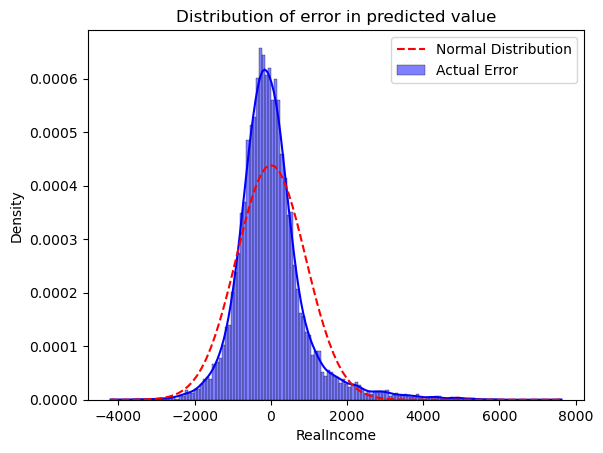

RMSE: 909.0416072468985
Range of actual values: 7893.649248464644
Approximately 79.83% of the time, the real value is lies in: predicted value ± 909.04
Approximately 94.88% of the time, the real value is lies in: predicted value ± 1818.08


In [69]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_MVL = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_MVL)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred_MVL)
print(f"R-squared Error: {r2}")
checkErorrs(y_pred_MVL,y_test)

## Random Forest Regressor 

Root Mean Squared Error (RMSE): 893.7384328398323


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


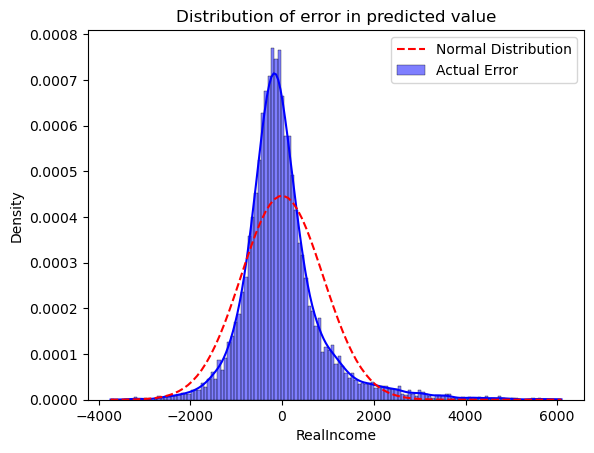

RMSE: 893.7384328398323
Range of actual values: 7893.649248464644
Approximately 79.94% of the time, the real value is lies in: predicted value ± 893.74
Approximately 94.48% of the time, the real value is lies in: predicted value ± 1787.48


In [70]:
rf_regressor = RandomForestRegressor(n_estimators=400, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred_RFR = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred_RFR)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
checkErorrs(y_pred_RFR,y_test)

## CatBoostRegressor 

Root Mean Squared Error (RMSE): 852.1783635244772
R-squared Error: 0.48170379777493777


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


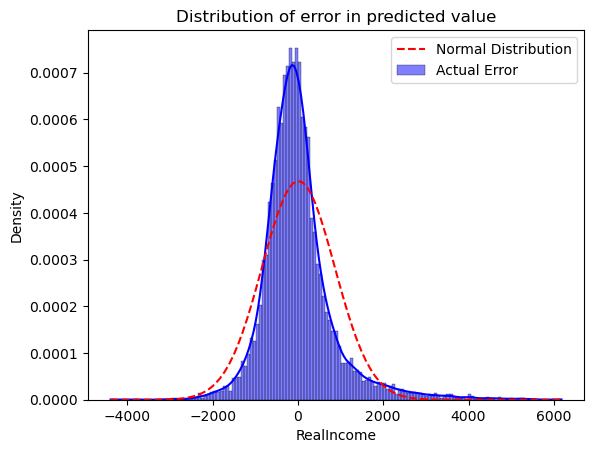

RMSE: 852.1783635244772
Range of actual values: 7893.649248464644
Approximately 80.73% of the time, the real value is lies in: predicted value ± 852.18
Approximately 94.65% of the time, the real value is lies in: predicted value ± 1704.36


In [71]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = CatBoostRegressor(iterations=600, learning_rate=0.1, loss_function='Tweedie:variance_power=1.009')
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=False)

y_pred_CAT = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_CAT))
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred_CAT)
print(f"R-squared Error: {r2}")
checkErorrs(y_pred_CAT,y_test)

Top 15 Most Important Features:
                                               Feature  Importance
2                                            YearsCode   51.691473
8                                 Country_Currency_num   24.706837
3                                         YearsCodePro    2.647750
7                                         Currency_num    1.816044
4                                              OrgSize    1.554187
126                         LanguageHaveWorkedWith_Nim    1.395082
334                ToolsTechHaveWorkedWith_Google Test    1.211617
149                   DatabaseHaveWorkedWith_Cassandra    1.160173
351                     ToolsTechHaveWorkedWith_Puppet    1.060823
33   Employment_Independent contractor, freelancer,...    0.463938
625                                  RemoteWork_Remote    0.427399
129                         LanguageHaveWorkedWith_PHP    0.411794
402                        OpSysProfessional use_MacOS    0.346671
506                           

<Figure size 10000x10000 with 0 Axes>

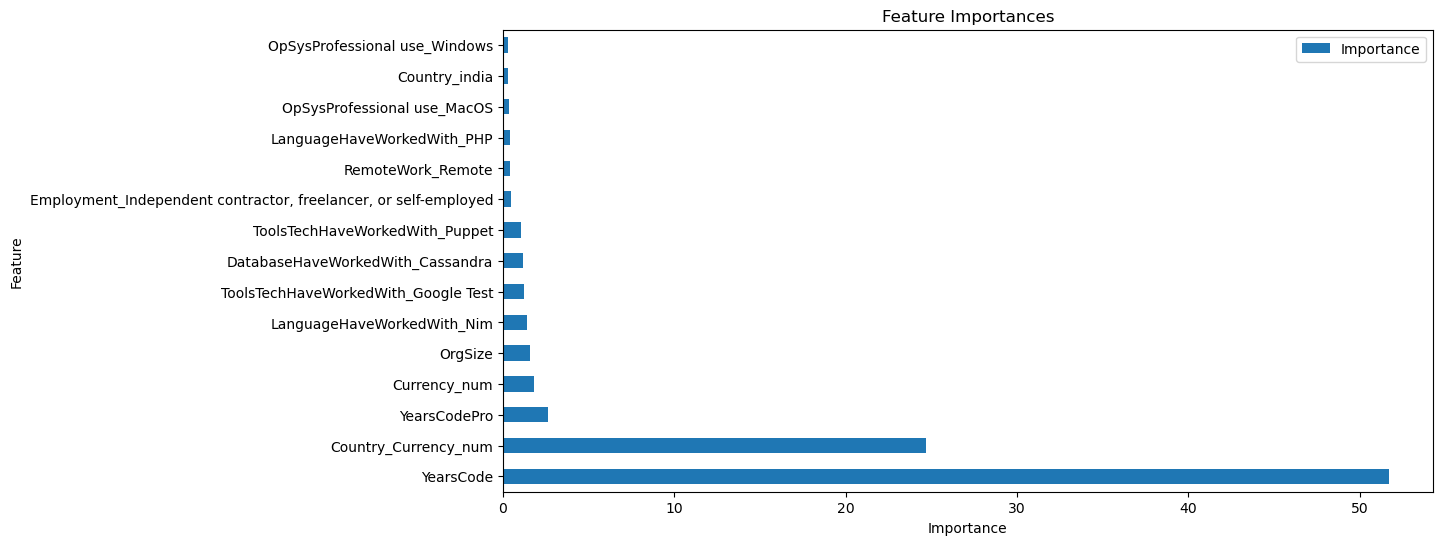

In [72]:
feature_importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

num_col_to_display = 15
print("Top 15 Most Important Features:")
print(feature_imp_df[:num_col_to_display])

plt.figure(figsize=(100, 100))
feature_imp_df[:num_col_to_display].plot(kind='barh', x='Feature', y='Importance', figsize=(12, 6))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Neural Network

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-08 14:11:37.917359: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-08 14:11:37.917384: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-08 14:11:37.917393: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-08 14:11:37.917407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-08 14:11:37.917417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow 

Epoch 1/100


2024-05-08 14:11:38.568629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 1796114.3750 - val_loss: 852577.6875
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 861730.4375 - val_loss: 841629.6250
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 829210.6250 - val_loss: 835263.5625
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 794897.1875 - val_loss: 859648.9375
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 814450.3125 - val_loss: 802802.3750
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 811820.3125 - val_loss: 839493.2500
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 777727.5000 - val_loss: 880404.7500
Epoch 8/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 762376.5625 - val_loss: 787339.3125
Epoch 9/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 767691.1875 - val_loss: 910331.3125
Epoch 10/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 752909.9375 - val_loss: 838607.5000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


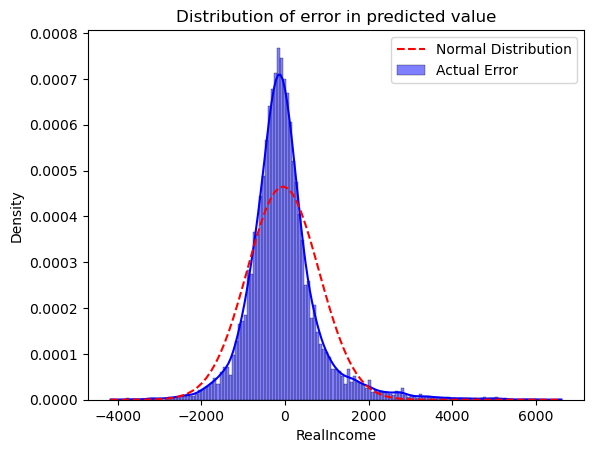

RMSE: 858.8677176832994
Range of actual values: 7893.649248464644
Approximately 79.32% of the time, the real value is lies in: predicted value ± 858.87
Approximately 94.60% of the time, the real value is lies in: predicted value ± 1717.74


In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def build_model(input_dim, dense_layer_units, dense_layer_activations):
    model = Sequential()
    model.add(Dense(dense_layer_units[0], activation=dense_layer_activations[0], input_dim=input_dim))

    for i in range(1, len(dense_layer_units)):
        model.add(Dense(dense_layer_units[i], activation=dense_layer_activations[i], kernel_regularizer=l1(0.2)))
        if i%2 == 0:
            model.add(BatchNormalization())
        else:
            model.add(Dropout(0.1))

    model.add(Dense(1, activation='linear'))
    return model

input_dim = X_train.shape[1]
dense_layer_units = [350, 250,100,10]
dense_layer_activations = ['linear', 'relu', 'relu', 'linear']

model = build_model(input_dim, dense_layer_units, dense_layer_activations)
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=25, validation_data=(X_val, y_val), callbacks=[early_stop])
y_pred_NN = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_NN)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred_NN)
print(f"R-squared Error: {r2}")
checkErorrs(y_pred_NN.ravel(),y_test)


/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/2846584458.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(var1, hist=False, kde=True, label='linear regression', ax=ax, kde_kws={'linewidth': 1,  'alpha': 0.7})
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/7b/d9x66shj237gkgzgdkp65nzw0000gp/T/ipykernel_14838/2846584458.py:9: UserWarning: 

`distplot` is a deprecated function and will

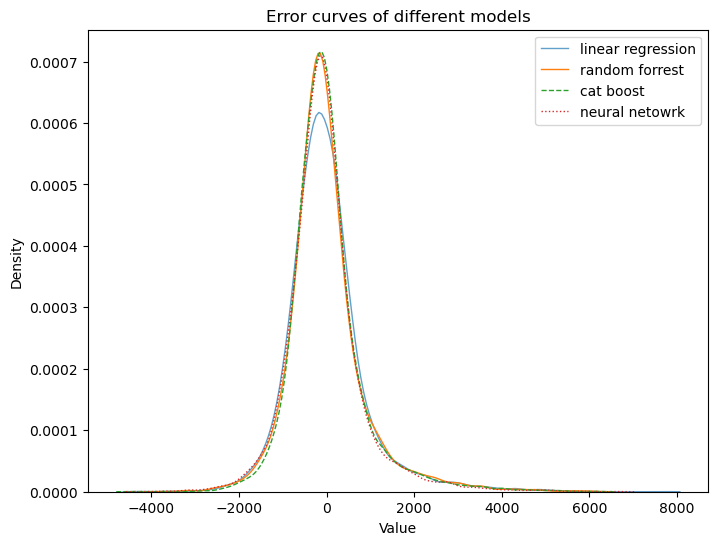

In [74]:
var1 = y_test - y_pred_MVL
var2 = y_test - y_pred_RFR
var3 = y_test - y_pred_CAT
var4 = y_test - (y_pred_NN.ravel())

fig, ax = plt.subplots(figsize=(8, 6))  # Create a single subplot

sns.distplot(var1, hist=False, kde=True, label='linear regression', ax=ax, kde_kws={'linewidth': 1,  'alpha': 0.7})
sns.distplot(var2, hist=False, kde=True, label='random forrest', ax=ax, kde_kws={'linewidth': 1})
sns.distplot(var3, hist=False, kde=True, label='cat boost', ax=ax, kde_kws={'linewidth': 1, 'linestyle':'--'})
sns.distplot(var4, hist=False, kde=True, label='neural netowrk', ax=ax, kde_kws={'linewidth': 1, 'linestyle': 'dotted'})

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title('Error curves of different models')

plt.show()